# TESS Atlas fit for TOI 274

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 274.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-274.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-274.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-274.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 274

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 274 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

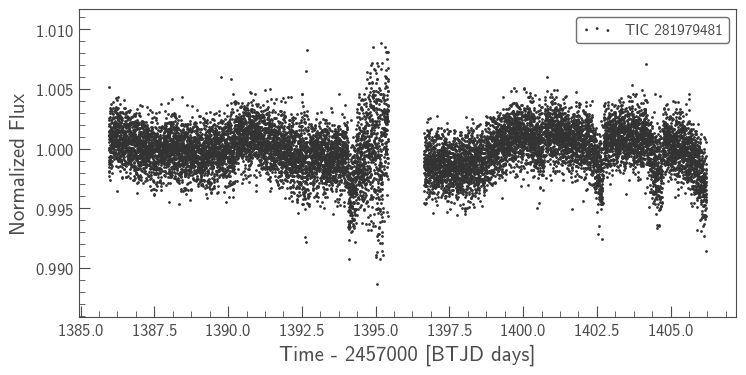

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -44846.24945095961 -> -43958.839059808684


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -25195.84435388282 -> -24880.19792430725


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -24880.19792430725 -> -24843.734804005227


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -24843.734804005227 -> -24843.724148993482


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -24843.724148993482 -> -24843.575414754723


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -24843.575414754723 -> -24843.54580588138


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -24843.54580588138 -> -24841.6172148809


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -24841.6172148809 -> -24841.617214880844


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -24841.617214880844 -> -24841.617214880844


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -24841.617214880844 -> -24841.617214880833


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -24841.617214880833 -> -24841.617214880695


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -24841.617214880695 -> -24841.617214880695


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -24841.617214880695 -> -24841.617214880695


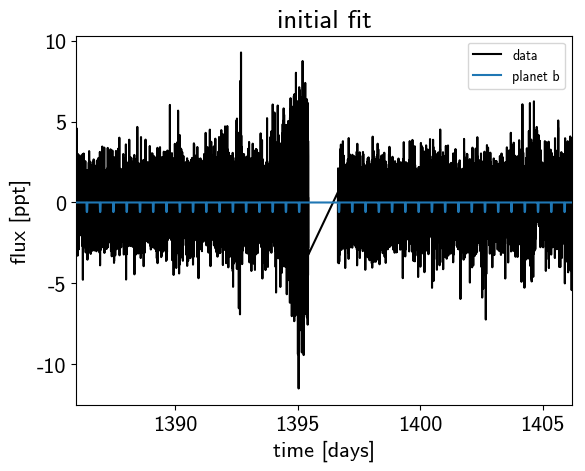

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:04, 19.81draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:06, 14.91draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:17,  5.35draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:19,  4.73draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:20,  4.37draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:22,  3.95draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:18,  4.55draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:23,  3.69draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:21,  3.83draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:21,  3.83draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:21,  3.85draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:20,  3.88draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:20,  3.86draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:20,  3.95draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:20,  3.85draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:18,  4.07draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:05<00:20,  3.78draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:18,  4.10draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:19,  3.79draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:18,  4.06draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:06<00:20,  3.54draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:17,  3.95draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:18,  3.77draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:18,  3.76draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:07<00:17,  3.99draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:17,  3.86draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:16,  4.05draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:08<00:16,  3.96draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:14,  4.36draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:08<00:16,  3.85draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:09<00:16,  3.70draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:09<00:15,  3.93draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:09<00:16,  3.68draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:09<00:14,  4.02draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:15,  3.82draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:10<00:14,  3.94draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:10<00:15,  3.71draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:10<00:14,  3.78draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:11<00:13,  3.93draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:11<00:14,  3.55draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:11<00:12,  4.02draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:12<00:16,  3.13draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:12<00:15,  3.26draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:12<00:12,  3.95draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:13<00:13,  3.54draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:13<00:14,  3.25draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:13<00:11,  3.89draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:14<00:13,  3.15draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:14<00:12,  3.40draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:15<00:11,  3.62draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:15<00:09,  3.81draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:16<00:09,  3.96draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:16<00:08,  4.07draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:16<00:07,  4.16draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:17<00:07,  4.21draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:17<00:06,  4.24draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:18<00:06,  4.25draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:18<00:05,  4.27draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:19<00:05,  4.19draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:19<00:04,  4.96draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:19<00:05,  3.97draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:20<00:04,  4.35draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:20<00:04,  3.97draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:20<00:04,  4.06draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:20<00:04,  3.35draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:21<00:03,  3.55draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:21<00:03,  3.68draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:22<00:02,  3.76draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:22<00:02,  3.92draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:23<00:01,  4.01draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:23<00:01,  4.72draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:23<00:01,  3.92draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:23<00:00,  4.73draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:24<00:00,  3.93draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:25<00:00,  1.58draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:26<00:00,  1.82draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:01, 59.67draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:00<00:07, 11.63draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:11,  7.50draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:01<00:14,  5.97draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:22,  3.83draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:21,  3.89draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:20,  4.01draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:03<00:20,  3.89draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:20,  3.80draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:16,  4.63draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:04<00:21,  3.62draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:20,  3.74draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:05<00:19,  3.79draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:05<00:15,  4.50draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:18,  3.79draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:06<00:19,  3.51draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:06<00:16,  4.09draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:06<00:16,  4.04draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:16,  4.17draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:07<00:16,  4.09draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:07<00:15,  4.16draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:07<00:15,  4.18draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:08<00:14,  4.21draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:08<00:14,  4.21draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:08<00:14,  4.19draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:08<00:14,  4.06draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:09<00:13,  4.38draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:09<00:15,  3.65draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:09<00:13,  4.35draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:09<00:14,  3.82draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:10<00:12,  4.32draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:10<00:14,  3.62draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:10<00:12,  4.25draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:10<00:14,  3.57draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:11<00:13,  3.63draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:11<00:12,  3.78draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:12<00:09,  4.87draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:12<00:11,  3.97draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:12<00:09,  4.75draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:12<00:10,  3.91draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:13<00:08,  4.67draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:13<00:10,  3.89draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:13<00:08,  4.66draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:13<00:10,  3.86draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:13<00:08,  4.66draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:14<00:10,  3.67draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:14<00:09,  3.80draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:15<00:08,  3.89draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:15<00:07,  3.97draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:16<00:05,  5.03draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:16<00:07,  3.93draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:16<00:06,  3.97draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:17<00:05,  4.04draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:17<00:05,  3.76draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:18<00:04,  4.76draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:18<00:04,  3.81draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:18<00:04,  3.94draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:19<00:03,  3.88draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:20<00:03,  3.95draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:20<00:02,  3.96draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:21<00:02,  3.95draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:21<00:01,  3.97draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:22<00:01,  3.95draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:22<00:00,  4.03draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:23<00:00,  2.92draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:24<00:00,  1.80draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:24<00:00,  1.53draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<00:53,  3.77draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<00:44,  4.51draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<00:37,  5.36draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:00<00:48,  4.12draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:00<00:41,  4.79draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<00:51,  3.87draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<00:42,  4.66draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<00:41,  4.77draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:01<00:46,  4.22draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:02<00:48,  4.01draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:46,  4.12draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:02<00:47,  4.01draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:03<00:48,  3.95draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:03<00:45,  4.17draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:03<00:46,  4.05draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:03<00:43,  4.28draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:03<00:45,  4.12draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:04<00:43,  4.29draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:04<00:38,  4.81draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:04<00:45,  4.09draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:04<00:39,  4.63draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:05<00:45,  4.00draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:05<00:39,  4.58draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:05<00:45,  3.98draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:05<00:39,  4.57draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:06<00:44,  4.00draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:06<00:38,  4.58draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:06<00:44,  3.97draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:06<00:38,  4.58draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:06<00:43,  4.00draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:07<00:37,  4.62draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:07<00:38,  4.51draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:07<00:38,  4.42draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:08<00:31,  5.26draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:08<00:28,  5.82draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:08<00:34,  4.81draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:08<00:29,  5.53draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:08<00:26,  6.17draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:09<00:35,  4.57draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:09<00:30,  5.27draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:09<00:37,  4.22draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:09<00:32,  4.95draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:10<00:38,  4.07draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:10<00:32,  4.85draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:10<00:28,  5.56draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:10<00:35,  4.36draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:10<00:30,  5.10draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:11<00:36,  4.16draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:11<00:31,  4.89draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:11<00:42,  3.52draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:12<00:39,  3.73draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:12<00:37,  3.88draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:13<00:36,  3.99draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:13<00:35,  4.06draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:14<00:34,  4.08draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:14<00:31,  4.50draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:14<00:37,  3.71draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:15<00:35,  3.83draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:15<00:34,  3.91draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:16<00:33,  3.99draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:16<00:26,  4.86draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:16<00:22,  5.84draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:16<00:19,  6.66draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:16<00:17,  7.09draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:16<00:22,  5.59draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:17<00:23,  5.36draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:17<00:26,  4.68draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:17<00:25,  4.81draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:17<00:27,  4.41draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:18<00:22,  5.33draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:18<00:23,  4.99draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:18<00:20,  5.79draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:18<00:26,  4.38draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:18<00:23,  5.01draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:19<00:28,  4.03draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:19<00:23,  4.89draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:19<00:24,  4.68draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:19<00:21,  5.22draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:20<00:26,  4.19draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:20<00:26,  4.12draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:20<00:27,  4.02draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:20<00:25,  4.25draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:21<00:25,  4.12draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:21<00:22,  4.69draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:21<00:22,  4.68draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:22<00:22,  4.53draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:22<00:22,  4.43draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:22<00:17,  5.58draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:23<00:22,  4.24draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:23<00:18,  5.07draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:23<00:23,  4.08draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:23<00:19,  4.86draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:24<00:23,  3.96draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:24<00:19,  4.73draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:24<00:23,  3.95draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:24<00:19,  4.73draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:25<00:22,  3.96draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:25<00:18,  4.73draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:25<00:22,  3.95draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:25<00:18,  4.75draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:25<00:16,  5.03draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:25<00:16,  5.19draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:26<00:18,  4.57draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:26<00:17,  4.81draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:26<00:18,  4.41draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:26<00:17,  4.60draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:27<00:18,  4.35draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:27<00:17,  4.50draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:27<00:17,  4.35draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:27<00:17,  4.41draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:28<00:17,  4.38draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:28<00:17,  4.23draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:28<00:16,  4.36draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:28<00:16,  4.24draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:28<00:16,  4.34draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:29<00:16,  4.23draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:29<00:15,  4.35draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:29<00:16,  4.24draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:29<00:15,  4.35draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:30<00:15,  4.20draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:30<00:14,  4.54draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:30<00:14,  4.36draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:31<00:14,  4.09draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:31<00:12,  4.80draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:31<00:15,  3.89draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:32<00:12,  4.60draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:32<00:14,  3.96draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:32<00:12,  4.67draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:32<00:13,  3.97draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:32<00:11,  4.58draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:33<00:13,  4.02draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:33<00:11,  4.61draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:33<00:12,  4.01draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:33<00:10,  4.63draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:34<00:12,  4.00draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:34<00:10,  4.66draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:34<00:11,  4.00draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:34<00:09,  4.64draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:35<00:11,  4.04draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:35<00:09,  4.65draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:35<00:10,  4.05draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:35<00:09,  4.65draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:36<00:10,  4.06draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:36<00:08,  4.61draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:36<00:09,  4.08draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:36<00:08,  4.62draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:36<00:09,  4.09draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:37<00:07,  4.65draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:37<00:08,  4.08draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:37<00:07,  4.67draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:37<00:08,  4.08draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:38<00:06,  4.67draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:38<00:07,  4.08draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:38<00:06,  4.63draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:38<00:07,  4.10draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:38<00:06,  4.64draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:39<00:06,  4.10draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:39<00:05,  4.65draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:39<00:06,  4.12draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:39<00:05,  4.65draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:40<00:05,  4.11draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:40<00:04,  4.66draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:40<00:05,  4.11draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:40<00:04,  4.63draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:41<00:04,  4.09draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:41<00:04,  4.50draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:41<00:04,  4.13draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:41<00:03,  4.46draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:42<00:03,  4.14draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:42<00:03,  4.45draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:42<00:03,  4.16draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:42<00:02,  4.44draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:42<00:02,  4.18draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:43<00:02,  4.45draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:43<00:02,  3.38draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:44<00:02,  2.90draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:44<00:02,  2.63draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:44<00:02,  2.86draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:44<00:01,  3.33draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:45<00:01,  2.85draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:45<00:01,  2.57draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:46<00:00,  2.40draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:46<00:00,  2.32draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:48<00:00,  1.16draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:14, 26.97draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:16, 24.17draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:19, 19.93draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:19, 19.87draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:00<00:20, 18.70draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:23, 16.59draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:00<00:25, 15.37draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:01<00:26, 14.37draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:01<00:27, 13.85draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:01<00:23, 15.93draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:01<00:21, 17.53draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:01<00:20, 18.00draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:01<00:19, 18.66draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:01<00:23, 15.60draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:02<00:19, 18.68draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:02<00:17, 20.66draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:02<00:15, 23.59draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:02<00:14, 23.96draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:02<00:14, 24.21draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:02<00:13, 26.08draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:02<00:12, 28.16draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:02<00:11, 29.70draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:03<00:16, 19.84draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:03<00:19, 16.96draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:03<00:21, 15.01draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:03<00:22, 14.24draws/s]

Sampling 2 chains:  20%|█▉        | 80/404 [00:04<00:19, 16.30draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:04<00:20, 15.74draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:04<00:17, 17.76draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:04<00:18, 17.24draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:04<00:18, 17.10draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:04<00:18, 16.96draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:04<00:19, 16.29draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:05<00:17, 17.27draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:05<00:15, 19.01draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:05<00:16, 18.44draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:05<00:15, 19.10draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:05<00:13, 21.43draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:05<00:14, 20.65draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:05<00:13, 21.11draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:06<00:17, 16.56draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:06<00:15, 18.55draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:06<00:17, 16.15draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:06<00:14, 18.45draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:06<00:12, 21.41draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:06<00:12, 21.15draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:07<00:11, 23.35draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:07<00:10, 25.44draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:07<00:09, 26.52draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:07<00:10, 23.65draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:07<00:11, 21.73draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:07<00:11, 21.60draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:07<00:10, 22.61draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:08<00:11, 20.55draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:08<00:10, 22.18draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:08<00:11, 20.23draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:08<00:09, 23.04draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:08<00:10, 22.06draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:08<00:11, 19.20draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:09<00:11, 19.26draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:09<00:10, 20.77draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:09<00:11, 18.49draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:09<00:10, 20.61draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:09<00:10, 19.24draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:09<00:11, 17.91draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:10<00:12, 16.01draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:10<00:12, 16.41draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:10<00:10, 19.00draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:10<00:08, 21.55draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:10<00:07, 24.24draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:10<00:06, 26.51draws/s]

Sampling 2 chains:  56%|█████▌    | 225/404 [00:10<00:06, 26.75draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:10<00:06, 29.15draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:11<00:06, 25.30draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:11<00:06, 25.32draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:11<00:06, 27.11draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:11<00:06, 23.14draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:11<00:08, 18.61draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:11<00:07, 20.19draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:12<00:08, 18.37draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:12<00:08, 18.07draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [00:12<00:07, 18.91draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:12<00:06, 20.71draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:12<00:06, 21.16draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:12<00:05, 23.98draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:12<00:05, 26.13draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:13<00:04, 29.85draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:13<00:03, 32.78draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:13<00:03, 33.32draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:13<00:03, 31.46draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:13<00:04, 26.75draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:13<00:04, 24.64draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:13<00:04, 24.84draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:14<00:03, 25.43draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:14<00:03, 28.14draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:14<00:03, 29.50draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [00:14<00:03, 24.38draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:14<00:04, 17.51draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [00:15<00:05, 15.54draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:15<00:05, 13.67draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:15<00:04, 15.86draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [00:15<00:03, 18.86draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [00:15<00:03, 20.42draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:15<00:03, 20.35draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:15<00:02, 21.91draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:16<00:03, 19.97draws/s]

Sampling 2 chains:  86%|████████▌ | 347/404 [00:16<00:03, 18.04draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:16<00:04, 11.68draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:16<00:04, 11.68draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:17<00:04, 10.57draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:17<00:04, 11.91draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [00:17<00:03, 11.70draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:17<00:03, 10.51draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:18<00:03, 11.39draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:18<00:03, 11.25draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:18<00:03, 10.80draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:18<00:03, 10.96draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:18<00:03, 10.05draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:19<00:02, 12.29draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:19<00:02, 11.91draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:19<00:02, 10.48draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:19<00:01, 12.90draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:19<00:01, 13.01draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:19<00:01, 14.43draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:19<00:00, 16.49draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [00:20<00:00, 14.46draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:20<00:00, 17.43draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:20<00:00, 17.21draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:20<00:00, 12.62draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:20<00:00, 19.28draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<00:15, 51.30draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:20, 39.21draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:00<00:23, 33.66draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:00<00:22, 34.94draws/s]

Sampling 2 chains:   3%|▎         | 21/804 [00:00<00:21, 36.66draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:00<00:30, 25.23draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:01<00:34, 22.80draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:01<00:32, 24.14draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:01<00:29, 26.28draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:01<00:28, 26.44draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:01<00:25, 30.38draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:01<00:34, 22.08draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:01<00:32, 23.33draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:02<00:31, 23.94draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:02<00:35, 20.91draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:02<00:30, 24.31draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:02<00:37, 19.55draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:02<00:36, 20.02draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:02<00:30, 23.73draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:02<00:27, 26.07draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:03<00:26, 27.78draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:03<00:25, 28.16draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:03<00:28, 25.46draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:03<00:27, 26.25draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:03<00:24, 29.45draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:03<00:21, 33.24draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:03<00:21, 32.27draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:03<00:22, 31.02draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:04<00:30, 22.65draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:04<00:32, 21.14draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:04<00:36, 18.69draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:04<00:36, 18.46draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:04<00:33, 20.51draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:05<00:29, 23.13draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:05<00:30, 22.17draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:05<00:25, 26.17draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:05<00:24, 26.70draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:05<00:24, 27.08draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:05<00:21, 30.88draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:05<00:20, 32.41draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:05<00:20, 30.76draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:06<00:17, 37.10draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:06<00:16, 37.21draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:06<00:15, 39.69draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:06<00:14, 41.89draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:06<00:14, 43.81draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:06<00:13, 45.75draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:06<00:14, 41.56draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:06<00:15, 37.68draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:07<00:15, 38.77draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:07<00:14, 39.67draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:07<00:13, 41.98draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:07<00:13, 41.47draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:07<00:15, 38.23draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:07<00:17, 31.80draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:07<00:21, 26.98draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:08<00:23, 23.54draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:08<00:23, 23.53draws/s]

Sampling 2 chains:  31%|███       | 249/804 [00:08<00:20, 27.25draws/s]

Sampling 2 chains:  31%|███▏      | 253/804 [00:08<00:19, 28.94draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [00:08<00:16, 33.60draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:08<00:16, 33.61draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [00:08<00:15, 33.73draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:09<00:14, 35.66draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:09<00:13, 38.61draws/s]

Sampling 2 chains:  35%|███▌      | 282/804 [00:09<00:12, 40.62draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:09<00:13, 38.31draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:09<00:13, 36.76draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:09<00:14, 35.94draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:09<00:14, 34.73draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:09<00:14, 34.80draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:09<00:14, 34.50draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:10<00:13, 36.44draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:10<00:12, 39.85draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:10<00:11, 41.46draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:10<00:12, 39.15draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:10<00:13, 34.44draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:10<00:17, 26.85draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [00:11<00:17, 26.99draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:11<00:17, 26.54draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:11<00:18, 24.35draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:11<00:19, 23.28draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [00:11<00:17, 25.35draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [00:11<00:14, 29.71draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:11<00:13, 32.90draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [00:11<00:11, 37.60draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:11<00:09, 43.13draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:12<00:08, 46.67draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:12<00:08, 47.55draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:12<00:10, 37.67draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [00:12<00:11, 35.42draws/s]

Sampling 2 chains:  50%|█████     | 406/804 [00:12<00:10, 36.31draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:12<00:11, 35.49draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [00:12<00:11, 34.91draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [00:13<00:11, 33.49draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:13<00:10, 34.75draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [00:13<00:09, 38.32draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:13<00:10, 34.02draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:13<00:12, 29.40draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:13<00:12, 30.22draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:13<00:11, 31.02draws/s]

Sampling 2 chains:  56%|█████▌    | 450/804 [00:14<00:10, 33.88draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [00:14<00:09, 36.39draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:14<00:09, 35.46draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:14<00:09, 34.55draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:14<00:09, 34.02draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [00:14<00:09, 33.54draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:14<00:08, 38.71draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:14<00:08, 36.29draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [00:15<00:08, 37.57draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [00:15<00:09, 34.01draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [00:15<00:09, 33.90draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [00:15<00:09, 33.72draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [00:15<00:08, 35.83draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [00:15<00:08, 35.25draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:15<00:07, 37.02draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:15<00:06, 41.42draws/s]

Sampling 2 chains:  66%|██████▌   | 527/804 [00:16<00:06, 41.13draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [00:16<00:07, 38.45draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:16<00:07, 36.46draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:16<00:08, 30.52draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:16<00:08, 31.27draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [00:16<00:08, 28.58draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [00:16<00:08, 31.16draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:17<00:08, 29.13draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [00:17<00:07, 31.05draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [00:17<00:07, 33.73draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:17<00:07, 30.27draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [00:17<00:07, 31.05draws/s]

Sampling 2 chains:  72%|███████▏  | 579/804 [00:17<00:07, 30.52draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [00:17<00:06, 31.46draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [00:18<00:08, 26.38draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:18<00:08, 24.24draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:18<00:09, 23.14draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [00:18<00:08, 24.39draws/s]

Sampling 2 chains:  75%|███████▍  | 602/804 [00:18<00:08, 22.87draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:18<00:08, 23.19draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:19<00:08, 22.99draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:19<00:07, 24.23draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [00:19<00:08, 23.12draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [00:19<00:08, 21.71draws/s]

Sampling 2 chains:  77%|███████▋  | 622/804 [00:19<00:07, 23.77draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [00:19<00:07, 24.71draws/s]

Sampling 2 chains:  78%|███████▊  | 628/804 [00:19<00:07, 24.74draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [00:19<00:07, 24.05draws/s]

Sampling 2 chains:  79%|███████▉  | 635/804 [00:20<00:06, 26.22draws/s]

Sampling 2 chains:  80%|███████▉  | 641/804 [00:20<00:05, 30.92draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [00:20<00:04, 32.76draws/s]

Sampling 2 chains:  81%|████████  | 650/804 [00:20<00:04, 35.05draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:20<00:03, 38.49draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:20<00:03, 41.31draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:20<00:03, 38.71draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [00:20<00:03, 36.42draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:21<00:03, 37.04draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [00:21<00:03, 30.56draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:21<00:03, 32.55draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:21<00:03, 33.73draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [00:21<00:03, 31.13draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [00:21<00:03, 32.61draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [00:21<00:02, 35.23draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [00:22<00:02, 36.81draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:22<00:02, 42.36draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [00:22<00:01, 44.75draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [00:22<00:01, 48.28draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [00:22<00:02, 33.48draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:23<00:02, 22.46draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [00:23<00:03, 18.88draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [00:23<00:03, 18.22draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [00:23<00:03, 15.44draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [00:23<00:03, 16.00draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:24<00:03, 16.07draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:24<00:02, 16.98draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [00:24<00:02, 16.81draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [00:24<00:02, 16.63draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [00:24<00:02, 17.47draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:24<00:01, 19.14draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [00:24<00:01, 20.52draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [00:24<00:01, 22.62draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [00:25<00:01, 23.19draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [00:25<00:01, 22.06draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:25<00:01, 20.06draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [00:25<00:00, 21.33draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:25<00:00, 22.30draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [00:25<00:00, 23.44draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [00:25<00:00, 23.90draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [00:26<00:00, 24.63draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [00:26<00:00, 25.20draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:26<00:00, 30.57draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/4404 [00:00<01:54, 38.43draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<01:59, 36.69draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<01:59, 36.87draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<02:31, 29.06draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:00<03:16, 22.30draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:00<03:13, 22.70draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:00<03:07, 23.36draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:01<03:09, 23.14draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<03:07, 23.34draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:01<02:44, 26.59draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:01<02:27, 29.64draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:01<02:48, 25.92draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:01<03:05, 23.51draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:02<04:05, 17.73draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:02<03:51, 18.79draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:02<03:30, 20.64draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:02<04:09, 17.40draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:02<04:18, 16.81draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:02<03:50, 18.79draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:03<03:19, 21.68draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:03<02:59, 24.15draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:03<02:36, 27.57draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:03<02:11, 32.74draws/s]

Sampling 2 chains:   2%|▏         | 95/4404 [00:03<01:51, 38.58draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:03<01:49, 39.19draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:03<01:55, 37.34draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:03<01:50, 38.87draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:04<01:55, 37.06draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:04<02:06, 33.85draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:04<02:00, 35.49draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:04<02:01, 35.25draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:04<01:57, 36.23draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:04<01:48, 39.30draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:04<02:02, 34.87draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:04<02:06, 33.68draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:05<02:17, 30.85draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:05<02:19, 30.40draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:05<02:14, 31.49draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:05<02:41, 26.27draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:05<02:42, 26.03draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:05<02:31, 27.96draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:05<02:23, 29.45draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:06<02:10, 32.42draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:06<01:53, 37.15draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:06<01:49, 38.40draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:06<01:51, 37.89draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:06<01:53, 37.10draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:06<01:57, 35.63draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:06<02:27, 28.44draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:07<02:46, 25.24draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:07<02:39, 26.31draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:07<02:45, 25.26draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:07<02:23, 29.06draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:07<02:32, 27.45draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:07<02:39, 26.21draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:07<02:27, 28.27draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:08<02:39, 26.09draws/s]

Sampling 2 chains:   5%|▌         | 242/4404 [00:08<02:31, 27.49draws/s]

Sampling 2 chains:   6%|▌         | 246/4404 [00:08<02:23, 28.97draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:08<02:22, 29.25draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:08<02:22, 29.12draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:08<02:14, 30.85draws/s]

Sampling 2 chains:   6%|▌         | 265/4404 [00:08<01:58, 34.85draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:08<02:16, 30.23draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:09<02:18, 29.93draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:09<03:05, 22.20draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:09<03:22, 20.40draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:09<03:15, 21.09draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [00:09<02:58, 23.03draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:09<02:39, 25.75draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:10<02:44, 24.92draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:10<03:03, 22.42draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:10<03:34, 19.17draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:10<03:23, 20.17draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:10<03:46, 18.11draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:10<03:09, 21.60draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:11<03:32, 19.22draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:11<03:08, 21.73draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [00:11<02:47, 24.33draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:11<02:26, 27.80draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:11<02:24, 28.28draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:11<02:17, 29.60draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [00:11<02:12, 30.63draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:12<02:02, 33.16draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:12<01:46, 38.00draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:12<01:43, 39.08draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:12<01:36, 41.95draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [00:12<01:43, 39.16draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:12<01:55, 34.90draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:12<01:56, 34.44draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:12<01:53, 35.37draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [00:13<01:44, 38.46draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [00:13<01:39, 40.42draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:13<01:38, 40.75draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:13<01:43, 38.72draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:13<01:39, 40.17draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:13<01:38, 40.56draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:13<01:43, 38.58draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:14<01:55, 34.43draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:14<02:04, 32.07draws/s]

Sampling 2 chains:  10%|▉         | 431/4404 [00:14<02:15, 29.26draws/s]

Sampling 2 chains:  10%|▉         | 435/4404 [00:14<02:28, 26.75draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:14<02:25, 27.24draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:14<02:40, 24.75draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [00:14<02:43, 24.20draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:15<03:38, 18.11draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:15<03:49, 17.22draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:15<03:27, 19.01draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [00:15<03:05, 21.24draws/s]

Sampling 2 chains:  10%|█         | 460/4404 [00:15<02:58, 22.07draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:15<02:40, 24.58draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:15<02:40, 24.49draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:16<02:29, 26.34draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [00:16<02:18, 28.27draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:16<02:00, 32.61draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:16<01:51, 35.21draws/s]

Sampling 2 chains:  11%|█         | 492/4404 [00:16<01:41, 38.57draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:16<01:34, 41.30draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [00:16<01:33, 41.59draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [00:16<01:32, 42.08draws/s]

Sampling 2 chains:  12%|█▏        | 514/4404 [00:17<01:28, 44.13draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:17<01:36, 40.13draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:17<01:38, 39.36draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:17<01:54, 33.71draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:17<02:08, 30.04draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:17<02:23, 26.89draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:17<02:26, 26.31draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:18<02:28, 25.98draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [00:18<02:19, 27.63draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:18<02:07, 30.16draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [00:18<02:03, 31.09draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [00:18<01:59, 32.30draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:18<01:57, 32.60draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:18<02:22, 26.88draws/s]

Sampling 2 chains:  13%|█▎        | 571/4404 [00:19<03:01, 21.13draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:19<03:03, 20.92draws/s]

Sampling 2 chains:  13%|█▎        | 577/4404 [00:19<03:18, 19.30draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [00:19<04:30, 14.14draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:19<04:15, 14.96draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [00:20<03:42, 17.15draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [00:20<03:35, 17.73draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:20<03:33, 17.87draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [00:20<03:28, 18.28draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:20<03:42, 17.15draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [00:20<04:01, 15.78draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [00:20<03:48, 16.65draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:20<03:53, 16.28draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [00:21<03:58, 15.92draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [00:21<03:55, 16.12draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [00:21<03:28, 18.24draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [00:21<03:10, 19.90draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [00:21<03:16, 19.23draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:21<03:28, 18.19draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [00:21<03:17, 19.13draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:22<03:32, 17.83draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [00:22<03:30, 17.99draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [00:22<03:39, 17.21draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [00:22<03:42, 16.95draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:22<03:33, 17.70draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [00:22<03:37, 17.31draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [00:22<03:40, 17.12draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:23<03:07, 20.11draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [00:23<03:28, 18.06draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [00:23<03:08, 19.97draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [00:23<03:20, 18.70draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [00:23<03:09, 19.77draws/s]

Sampling 2 chains:  15%|█▍        | 655/4404 [00:23<03:22, 18.53draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [00:23<03:36, 17.28draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [00:24<04:32, 13.75draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [00:24<03:59, 15.64draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:24<03:59, 15.64draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [00:24<04:00, 15.56draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:24<03:54, 15.90draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [00:24<03:26, 18.04draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [00:24<03:35, 17.29draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [00:25<03:29, 17.82draws/s]

Sampling 2 chains:  15%|█▌        | 678/4404 [00:25<03:22, 18.40draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:25<03:33, 17.41draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [00:25<03:27, 17.95draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [00:25<03:13, 19.27draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [00:25<03:21, 18.42draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [00:25<03:05, 20.04draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [00:25<02:54, 21.29draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [00:26<02:39, 23.28draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [00:26<02:37, 23.57draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:26<02:32, 24.21draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [00:26<02:47, 22.04draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [00:26<02:40, 22.96draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [00:26<02:39, 23.21draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [00:26<02:49, 21.73draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:26<02:41, 22.76draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [00:27<02:36, 23.46draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [00:27<02:33, 24.04draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [00:27<02:19, 26.29draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [00:27<02:18, 26.55draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [00:27<02:06, 29.08draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:27<02:03, 29.61draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:27<01:55, 31.66draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [00:27<01:52, 32.39draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [00:28<01:50, 32.94draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [00:28<01:54, 31.82draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [00:28<01:55, 31.47draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:28<01:56, 31.33draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [00:28<02:12, 27.50draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [00:28<02:17, 26.44draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [00:28<02:21, 25.58draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [00:29<02:26, 24.81draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [00:29<02:11, 27.60draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [00:29<02:11, 27.49draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [00:29<02:14, 26.80draws/s]

Sampling 2 chains:  18%|█▊        | 791/4404 [00:29<02:18, 26.18draws/s]

Sampling 2 chains:  18%|█▊        | 796/4404 [00:29<01:58, 30.43draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [00:29<01:52, 31.99draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [00:29<02:15, 26.52draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [00:30<02:10, 27.48draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [00:30<02:09, 27.70draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:30<02:04, 28.83draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:30<01:58, 30.21draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [00:30<01:58, 30.32draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [00:30<01:57, 30.40draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [00:30<01:51, 32.05draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:30<01:50, 32.41draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [00:31<01:51, 31.94draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [00:31<01:51, 31.80draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [00:31<01:51, 31.90draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [00:31<01:51, 31.75draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [00:31<01:57, 30.30draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [00:31<01:55, 30.70draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [00:31<01:51, 31.85draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [00:32<01:41, 34.74draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [00:32<01:54, 30.84draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [00:32<02:06, 27.89draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [00:32<01:56, 30.13draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [00:32<01:50, 31.89draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [00:32<01:46, 32.81draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [00:32<01:45, 33.10draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [00:33<02:00, 29.04draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [00:33<01:55, 30.31draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [00:33<01:46, 32.87draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [00:33<01:36, 36.10draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [00:33<01:48, 32.00draws/s]

Sampling 2 chains:  21%|██        | 924/4404 [00:33<01:47, 32.31draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [00:33<01:46, 32.62draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [00:33<01:39, 34.95draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:34<01:40, 34.59draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [00:34<01:44, 33.10draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [00:34<01:39, 34.59draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [00:34<01:45, 32.83draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [00:34<01:58, 29.25draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [00:34<02:16, 25.31draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:34<02:05, 27.41draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [00:34<02:08, 26.79draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [00:35<02:09, 26.45draws/s]

Sampling 2 chains:  22%|██▏       | 970/4404 [00:35<02:08, 26.79draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [00:35<01:53, 30.16draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [00:35<01:49, 31.23draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [00:35<01:46, 32.01draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [00:35<01:45, 32.46draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [00:35<01:43, 32.87draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [00:35<01:50, 30.87draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [00:36<01:47, 31.68draws/s]

Sampling 2 chains:  23%|██▎       | 1005/4404 [00:36<02:00, 28.32draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [00:36<01:53, 29.80draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [00:36<01:50, 30.65draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [00:36<02:01, 27.84draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [00:36<01:53, 29.73draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [00:36<01:49, 30.85draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [00:37<01:40, 33.60draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [00:37<01:29, 37.44draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [00:37<01:31, 36.57draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [00:37<01:30, 36.96draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [00:37<01:33, 36.06draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [00:37<01:34, 35.51draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [00:37<01:36, 34.80draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [00:37<01:43, 32.30draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [00:38<01:49, 30.60draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [00:38<02:22, 23.46draws/s]

Sampling 2 chains:  24%|██▍       | 1072/4404 [00:38<02:19, 23.93draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [00:38<02:15, 24.60draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [00:38<02:16, 24.31draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [00:38<02:36, 21.26draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [00:39<02:22, 23.31draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [00:39<02:03, 26.78draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [00:39<02:00, 27.59draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [00:39<01:54, 28.95draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [00:39<01:45, 31.25draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [00:39<01:57, 28.18draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [00:39<01:47, 30.51draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [00:39<01:52, 29.27draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [00:40<01:43, 31.76draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [00:40<02:13, 24.56draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [00:40<02:12, 24.69draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [00:40<02:06, 25.85draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [00:40<01:57, 27.80draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [00:40<01:48, 30.12draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [00:40<01:47, 30.37draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [00:40<01:48, 30.07draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [00:41<01:45, 30.75draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [00:41<01:41, 31.93draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [00:41<01:40, 32.37draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [00:41<01:45, 30.66draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [00:41<01:43, 31.24draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [00:41<01:42, 31.59draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [00:41<01:38, 32.87draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [00:42<01:31, 35.15draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [00:42<01:33, 34.54draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [00:42<01:31, 35.22draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [00:42<01:33, 34.31draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [00:42<01:34, 34.00draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [00:42<01:33, 34.21draws/s]

Sampling 2 chains:  27%|██▋       | 1203/4404 [00:42<01:39, 32.30draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [00:42<01:33, 34.11draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [00:43<01:46, 29.85draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [00:43<01:44, 30.63draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [00:43<01:48, 29.38draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [00:43<01:43, 30.78draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [00:43<01:43, 30.83draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [00:43<01:50, 28.71draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [00:43<01:49, 28.96draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [00:43<01:43, 30.48draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [00:44<01:36, 32.63draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [00:44<01:39, 31.79draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [00:44<01:42, 30.78draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [00:44<01:41, 31.05draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [00:44<01:44, 30.06draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [00:44<01:37, 32.35draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [00:44<01:35, 32.95draws/s]

Sampling 2 chains:  29%|██▉       | 1274/4404 [00:45<02:00, 25.91draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [00:45<02:07, 24.49draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [00:45<02:20, 22.20draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [00:45<02:29, 20.90draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [00:45<02:30, 20.71draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [00:46<03:34, 14.55draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [00:46<03:33, 14.60draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [00:46<03:31, 14.68draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [00:46<03:49, 13.57draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [00:46<04:03, 12.75draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [00:46<03:29, 14.84draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [00:46<03:07, 16.53draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [00:47<03:41, 14.01draws/s]

Sampling 2 chains:  30%|██▉       | 1307/4404 [00:47<04:03, 12.74draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [00:47<04:22, 11.77draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [00:47<05:01, 10.27draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [00:48<05:04, 10.16draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [00:48<04:56, 10.40draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [00:48<04:18, 11.95draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [00:48<04:13, 12.14draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [00:48<04:03, 12.66draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [00:48<03:22, 15.17draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [00:49<05:12,  9.85draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [00:49<05:25,  9.43draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [00:49<05:34,  9.19draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [00:49<05:40,  9.03draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [00:50<05:43,  8.92draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [00:50<05:47,  8.83draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [00:50<05:49,  8.77draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [00:50<05:50,  8.75draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [00:50<05:46,  8.85draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [00:50<04:57, 10.29draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [00:50<05:14,  9.73draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [00:51<04:33, 11.18draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [00:51<03:55, 12.98draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [00:51<03:37, 14.02draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [00:51<03:25, 14.84draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [00:51<02:59, 16.94draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [00:51<02:59, 16.96draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [00:51<03:01, 16.77draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [00:51<02:59, 16.98draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [00:52<02:56, 17.17draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [00:52<02:39, 19.07draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [00:52<02:39, 18.99draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [00:52<02:35, 19.51draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [00:52<02:41, 18.77draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [00:52<02:36, 19.31draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [00:52<02:41, 18.70draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [00:52<02:45, 18.26draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [00:53<02:47, 17.97draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [00:53<02:50, 17.74draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [00:53<02:33, 19.57draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [00:53<02:39, 18.83draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [00:53<02:53, 17.38draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [00:53<02:53, 17.31draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [00:53<02:53, 17.28draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [00:54<02:40, 18.68draws/s]

Sampling 2 chains:  32%|███▏      | 1407/4404 [00:54<02:35, 19.28draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [00:54<02:15, 22.16draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [00:54<02:09, 23.15draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [00:54<02:13, 22.38draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [00:54<01:59, 25.04draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [00:54<01:55, 25.85draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [00:55<02:03, 24.07draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [00:55<02:09, 22.91draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [00:55<02:05, 23.66draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [00:55<02:19, 21.33draws/s]

Sampling 2 chains:  33%|███▎      | 1441/4404 [00:55<02:28, 19.97draws/s]

Sampling 2 chains:  33%|███▎      | 1444/4404 [00:55<02:26, 20.14draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [00:55<02:21, 20.84draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [00:56<02:17, 21.43draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [00:56<02:47, 17.62draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [00:56<03:39, 13.43draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [00:56<04:15, 11.52draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [00:56<04:36, 10.66draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [00:57<04:10, 11.76draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [00:57<04:37, 10.62draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [00:57<04:04, 12.02draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [00:57<04:07, 11.87draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [00:57<04:09, 11.78draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [00:57<03:44, 13.05draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [00:58<03:57, 12.34draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [00:58<03:36, 13.51draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [00:58<03:22, 14.49draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [00:58<03:14, 15.06draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [00:58<03:07, 15.59draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [00:58<02:46, 17.49draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [00:58<02:50, 17.11draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [00:58<02:53, 16.76draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [00:59<02:58, 16.37draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [00:59<02:44, 17.70draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [00:59<03:00, 16.08draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [00:59<02:43, 17.77draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [00:59<02:30, 19.33draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [00:59<02:44, 17.59draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [01:00<03:15, 14.82draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [01:00<03:14, 14.87draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [01:00<03:32, 13.64draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [01:00<03:33, 13.57draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [01:00<03:05, 15.58draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [01:00<02:49, 16.99draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [01:00<02:32, 18.89draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [01:01<02:29, 19.29draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [01:01<02:17, 20.89draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [01:01<02:16, 21.05draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [01:01<02:11, 21.79draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [01:01<02:01, 23.52draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [01:01<02:07, 22.48draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [01:01<02:00, 23.65draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [01:02<02:08, 22.29draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [01:02<02:01, 23.54draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [01:02<01:58, 24.05draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [01:02<01:56, 24.53draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [01:02<02:27, 19.34draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [01:02<02:33, 18.54draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [01:02<02:20, 20.23draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [01:03<02:02, 23.04draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [01:03<01:58, 23.83draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [01:03<02:05, 22.53draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [01:03<02:01, 23.29draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [01:03<01:57, 24.00draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [01:03<01:55, 24.37draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [01:03<01:41, 27.60draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [01:03<01:36, 29.14draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [01:04<01:44, 26.86draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [01:04<01:37, 28.66draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [01:04<01:26, 32.33draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [01:04<01:25, 32.84draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [01:04<01:24, 33.20draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [01:04<01:15, 36.77draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [01:04<01:17, 35.98draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [01:04<01:11, 38.74draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [01:04<01:10, 39.48draws/s]

Sampling 2 chains:  37%|███▋      | 1640/4404 [01:05<01:10, 39.33draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [01:05<01:17, 35.75draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [01:05<01:18, 35.27draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [01:05<01:19, 34.80draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [01:05<01:11, 38.51draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [01:05<01:05, 41.58draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [01:05<01:07, 40.69draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [01:06<01:06, 41.20draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [01:06<01:08, 39.96draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [01:06<01:07, 40.25draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [01:06<01:03, 42.74draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [01:06<01:08, 39.42draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [01:06<01:17, 34.93draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [01:06<01:17, 34.71draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [01:06<01:10, 37.98draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [01:07<01:13, 36.79draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [01:07<01:11, 37.49draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [01:07<01:14, 35.87draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [01:07<01:11, 37.27draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [01:07<01:18, 34.08draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [01:07<01:15, 35.39draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [01:07<01:19, 33.63draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [01:07<01:27, 30.58draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [01:08<01:17, 34.08draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [01:08<01:15, 35.17draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [01:08<01:09, 38.15draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [01:08<01:07, 39.11draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [01:08<01:05, 40.31draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [01:08<01:08, 38.44draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [01:08<01:11, 36.82draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [01:08<01:15, 34.63draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [01:09<01:06, 39.22draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [01:09<01:02, 41.55draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [01:09<00:57, 45.60draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [01:09<01:02, 41.87draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [01:09<01:06, 39.08draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [01:09<00:59, 43.12draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [01:09<01:05, 39.50draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [01:10<01:10, 36.44draws/s]

Sampling 2 chains:  42%|████▏     | 1832/4404 [01:10<01:10, 36.53draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [01:10<01:12, 35.33draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [01:10<01:13, 34.74draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [01:10<01:04, 39.52draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [01:10<01:02, 40.62draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [01:10<01:05, 39.17draws/s]

Sampling 2 chains:  42%|████▏     | 1862/4404 [01:10<01:04, 39.47draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [01:11<01:11, 35.45draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [01:11<01:09, 36.31draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [01:11<01:11, 35.56draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [01:11<01:04, 39.09draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [01:11<00:58, 43.35draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [01:11<00:55, 45.43draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [01:11<01:01, 40.91draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [01:12<01:23, 29.91draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [01:12<01:59, 20.93draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [01:12<02:20, 17.75draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [01:12<02:43, 15.18draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [01:13<02:51, 14.53draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [01:13<02:52, 14.38draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [01:13<02:48, 14.76draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [01:13<02:35, 15.90draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [01:13<02:14, 18.40draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [01:13<02:24, 17.05draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [01:14<02:33, 16.12draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [01:14<02:29, 16.52draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [01:14<02:32, 16.18draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [01:14<02:50, 14.42draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [01:14<02:30, 16.38draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [01:14<02:30, 16.37draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [01:14<02:28, 16.55draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [01:15<02:34, 15.83draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [01:15<02:40, 15.29draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [01:15<02:37, 15.58draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [01:15<03:00, 13.55draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [01:15<02:54, 14.05draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [01:15<02:32, 16.07draws/s]

Sampling 2 chains:  45%|████▍     | 1963/4404 [01:15<02:32, 15.98draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [01:15<02:31, 16.13draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [01:16<02:23, 16.98draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [01:16<02:46, 14.61draws/s]

Sampling 2 chains:  45%|████▍     | 1971/4404 [01:16<02:46, 14.61draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [01:16<03:03, 13.26draws/s]

Sampling 2 chains:  45%|████▍     | 1975/4404 [01:16<02:53, 13.96draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [01:16<02:39, 15.20draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [01:17<03:33, 11.38draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [01:17<03:36, 11.18draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [01:17<03:37, 11.11draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [01:17<03:37, 11.11draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [01:17<03:01, 13.33draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [01:18<02:50, 14.14draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [01:18<02:46, 14.50draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [01:18<03:01, 13.24draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [01:18<02:46, 14.44draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [01:18<03:18, 12.13draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [01:18<03:04, 13.04draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [01:19<03:52, 10.32draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [01:19<04:10,  9.57draws/s]

Sampling 2 chains:  46%|████▌     | 2010/4404 [01:19<04:04,  9.79draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [01:19<03:36, 11.06draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [01:19<04:00,  9.95draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [01:20<03:32, 11.24draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [01:20<03:06, 12.81draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [01:20<02:43, 14.55draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [01:20<03:01, 13.13draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [01:20<02:52, 13.80draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [01:20<02:43, 14.56draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [01:21<03:32, 11.18draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [01:21<03:11, 12.41draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [01:21<02:55, 13.52draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [01:21<02:44, 14.36draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [01:21<02:42, 14.57draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [01:21<02:30, 15.69draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [01:21<02:50, 13.87draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [01:22<02:45, 14.23draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [01:22<02:19, 16.88draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [01:22<02:23, 16.37draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [01:22<02:26, 16.07draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [01:22<02:26, 16.09draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [01:22<02:12, 17.73draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [01:22<02:16, 17.17draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [01:22<02:20, 16.66draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [01:23<02:20, 16.64draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [01:23<02:21, 16.54draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [01:23<02:21, 16.51draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [01:23<02:12, 17.57draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [01:23<02:16, 17.07draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [01:23<02:36, 14.89draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [01:23<02:23, 16.16draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [01:24<02:10, 17.82draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [01:24<02:02, 18.97draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [01:24<02:59, 12.90draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [01:24<03:00, 12.83draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [01:24<02:49, 13.67draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [01:24<03:01, 12.72draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [01:25<02:41, 14.30draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [01:25<02:42, 14.18draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [01:25<02:28, 15.50draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [01:25<02:46, 13.84draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [01:25<03:02, 12.61draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [01:25<02:55, 13.12draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [01:26<02:38, 14.51draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [01:26<02:18, 16.61draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [01:26<02:02, 18.68draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [01:26<02:01, 18.89draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [01:26<02:03, 18.50draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [01:26<01:50, 20.67draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [01:26<01:57, 19.39draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [01:27<02:18, 16.37draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [01:27<02:18, 16.42draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [01:27<02:38, 14.37draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [01:27<02:31, 14.95draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [01:27<02:48, 13.48draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [01:27<02:37, 14.36draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [01:27<02:38, 14.30draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [01:28<02:20, 16.12draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [01:28<02:02, 18.36draws/s]

Sampling 2 chains:  49%|████▉     | 2150/4404 [01:28<01:53, 19.91draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [01:28<01:59, 18.82draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [01:28<01:51, 20.17draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [01:28<01:49, 20.51draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [01:28<01:44, 21.40draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [01:29<01:41, 21.94draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [01:29<01:38, 22.69draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [01:29<01:37, 22.93draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [01:29<01:28, 25.21draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [01:29<01:29, 24.80draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [01:29<01:28, 25.17draws/s]

Sampling 2 chains:  50%|████▉     | 2186/4404 [01:29<01:32, 23.93draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [01:29<01:35, 23.21draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [01:30<01:27, 25.19draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [01:30<01:28, 24.99draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [01:30<01:29, 24.77draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [01:30<01:26, 25.44draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [01:30<01:27, 25.00draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [01:30<01:31, 24.01draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [01:30<01:18, 27.79draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [01:30<01:14, 29.18draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [01:31<01:15, 28.96draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [01:31<01:21, 26.73draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [01:31<01:24, 25.69draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [01:31<01:25, 25.29draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [01:31<01:22, 26.29draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [01:31<01:36, 22.42draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [01:31<01:23, 25.75draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [01:32<01:28, 24.51draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [01:32<01:28, 24.36draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [01:32<01:21, 26.33draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [01:32<01:38, 21.76draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [01:32<01:29, 23.96draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [01:32<01:34, 22.70draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [01:32<01:32, 23.24draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [01:33<01:36, 22.11draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [01:33<01:32, 23.04draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [01:33<01:29, 23.72draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [01:33<01:26, 24.52draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [01:33<01:25, 24.91draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [01:33<01:24, 25.05draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [01:33<01:16, 27.60draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [01:33<01:15, 28.12draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [01:34<01:13, 28.58draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [01:34<01:13, 28.65draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [01:34<01:11, 29.33draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [01:34<01:05, 31.80draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [01:34<00:57, 36.46draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [01:34<00:54, 37.97draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [01:34<00:58, 35.28draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [01:35<01:04, 32.19draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [01:35<01:04, 32.13draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [01:35<01:10, 29.45draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [01:35<01:09, 29.71draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [01:35<00:59, 34.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [01:35<01:02, 33.01draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [01:35<01:02, 32.72draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [01:35<01:02, 32.83draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [01:36<01:02, 32.84draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [01:36<01:02, 32.50draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [01:36<01:02, 32.35draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [01:36<01:04, 31.43draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [01:36<01:03, 32.04draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [01:36<01:02, 32.46draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [01:36<01:01, 32.74draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [01:36<01:00, 33.00draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [01:37<00:58, 34.27draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [01:37<00:59, 33.77draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [01:37<01:00, 33.20draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [01:37<00:59, 33.63draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [01:37<00:56, 35.43draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [01:37<00:51, 38.42draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [01:37<00:53, 36.85draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [01:37<00:53, 36.84draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [01:38<00:58, 34.01draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [01:38<00:55, 35.52draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [01:38<00:58, 33.76draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [01:38<01:03, 30.83draws/s]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [01:38<00:58, 33.36draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [01:38<00:59, 32.79draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [01:38<01:02, 31.29draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [01:38<00:55, 34.77draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [01:39<01:02, 30.91draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [01:39<00:56, 34.13draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [01:39<01:00, 31.90draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [01:39<01:14, 25.68draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [01:39<01:14, 25.81draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [01:39<01:18, 24.59draws/s]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [01:39<01:12, 26.58draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [01:40<01:09, 27.45draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [01:40<01:17, 24.66draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [01:40<01:19, 24.02draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [01:40<01:28, 21.49draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [01:40<01:27, 21.63draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [01:40<01:20, 23.64draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [01:40<01:15, 24.97draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [01:41<01:17, 24.32draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [01:41<01:15, 24.87draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [01:41<01:12, 26.09draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [01:41<01:17, 24.18draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [01:41<01:20, 23.24draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [01:41<01:11, 26.25draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [01:41<01:04, 28.89draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [01:42<01:02, 29.72draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [01:42<00:58, 31.72draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [01:42<01:01, 30.17draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [01:42<00:57, 32.35draws/s]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [01:42<00:56, 32.43draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [01:42<00:57, 31.78draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [01:42<00:57, 31.78draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [01:43<00:58, 31.51draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [01:43<01:00, 30.27draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [01:43<01:07, 27.07draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [01:43<01:06, 27.40draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [01:43<01:07, 26.85draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [01:43<01:11, 25.42draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [01:43<01:08, 26.26draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [01:43<01:07, 26.92draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [01:44<01:04, 27.85draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [01:44<01:07, 26.47draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [01:44<01:09, 25.71draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [01:44<01:10, 25.57draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [01:44<01:05, 27.48draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [01:44<01:02, 28.43draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [01:44<01:02, 28.56draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [01:44<01:00, 29.19draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [01:45<00:59, 29.87draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [01:45<01:00, 29.22draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [01:45<01:00, 29.20draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [01:45<01:02, 28.19draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [01:45<00:57, 30.32draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [01:45<00:51, 34.29draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [01:45<01:00, 28.92draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [01:46<00:59, 29.11draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [01:46<01:03, 27.57draws/s]

Sampling 2 chains:  61%|██████    | 2668/4404 [01:46<01:06, 26.07draws/s]

Sampling 2 chains:  61%|██████    | 2671/4404 [01:46<01:04, 27.08draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [01:46<01:11, 24.14draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [01:46<01:04, 26.73draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [01:46<00:58, 29.28draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [01:47<00:57, 29.62draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [01:47<00:53, 31.91draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [01:47<00:57, 29.57draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [01:47<00:53, 32.07draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [01:47<00:52, 32.25draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [01:47<00:54, 31.17draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [01:47<01:05, 25.68draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [01:48<01:18, 21.60draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [01:48<01:10, 24.05draws/s]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [01:48<01:09, 24.08draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [01:48<01:10, 23.74draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [01:48<01:20, 20.71draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [01:48<01:17, 21.49draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [01:48<01:14, 22.33draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [01:48<01:07, 24.71draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [01:49<01:02, 26.60draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [01:49<00:58, 28.25draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [01:49<00:53, 30.96draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [01:49<00:50, 32.47draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [01:49<00:48, 33.71draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [01:49<00:44, 36.91draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [01:49<00:46, 35.33draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [01:49<00:50, 32.39draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [01:50<00:51, 31.58draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [01:50<00:49, 32.86draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [01:50<00:48, 33.37draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [01:50<00:46, 34.46draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [01:50<00:48, 33.41draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [01:50<00:47, 33.60draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [01:50<00:45, 35.14draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [01:51<00:49, 31.99draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [01:51<00:50, 31.48draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [01:51<00:57, 27.42draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [01:51<01:00, 26.11draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [01:51<00:58, 27.25draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [01:51<00:59, 26.63draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [01:51<01:02, 25.03draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [01:52<01:00, 25.87draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [01:52<00:59, 26.30draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [01:52<01:00, 25.99draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [01:52<01:01, 25.28draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [01:52<01:03, 24.52draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [01:52<01:04, 24.11draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [01:52<01:05, 23.85draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [01:52<01:03, 24.23draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [01:53<01:02, 24.87draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [01:53<01:04, 23.85draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [01:53<01:06, 23.28draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [01:53<01:04, 23.68draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [01:53<01:02, 24.35draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [01:53<01:03, 24.04draws/s]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [01:53<01:03, 24.22draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [01:53<01:01, 24.93draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [01:54<01:01, 24.62draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [01:54<01:00, 25.26draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [01:54<00:59, 25.54draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [01:54<00:52, 28.60draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [01:54<00:55, 27.26draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [01:54<00:57, 26.37draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [01:54<00:55, 26.87draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [01:54<00:52, 28.54draws/s]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [01:55<00:50, 29.84draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [01:55<00:49, 29.88draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [01:55<00:48, 30.61draws/s]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [01:55<00:43, 34.28draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [01:55<00:45, 32.57draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [01:55<00:47, 31.15draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [01:55<00:48, 30.36draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [01:56<00:50, 29.12draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [01:56<00:48, 30.37draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [01:56<00:47, 30.59draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [01:56<00:44, 32.44draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [01:56<00:42, 33.74draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [01:56<00:40, 35.29draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [01:56<00:41, 35.03draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [01:56<00:42, 33.95draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [01:57<00:49, 28.84draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [01:57<00:49, 28.93draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [01:57<00:47, 30.15draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [01:57<00:44, 32.08draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [01:57<00:39, 35.84draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [01:57<00:40, 34.91draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [01:57<00:41, 34.13draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [01:57<00:41, 33.89draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [01:58<00:42, 32.91draws/s]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [01:58<00:43, 31.84draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [01:58<00:41, 33.73draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [01:58<00:41, 33.23draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [01:58<00:41, 33.38draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [01:58<00:41, 32.85draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [01:58<00:37, 36.26draws/s]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [01:58<00:40, 33.86draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [01:59<00:40, 33.60draws/s]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [01:59<00:37, 36.58draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [01:59<00:38, 35.11draws/s]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [01:59<00:37, 35.89draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [01:59<00:42, 31.30draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [01:59<00:46, 29.13draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [01:59<00:51, 25.87draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [02:00<00:54, 24.48draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [02:00<00:49, 26.86draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [02:00<00:49, 26.67draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [02:00<00:48, 27.42draws/s]

Sampling 2 chains:  70%|███████   | 3087/4404 [02:00<00:46, 28.05draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [02:00<00:42, 30.71draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [02:00<00:40, 32.22draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [02:00<00:39, 33.10draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [02:01<00:39, 32.96draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [02:01<00:38, 33.56draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [02:01<00:36, 35.19draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [02:01<00:36, 34.90draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [02:01<00:37, 34.25draws/s]

Sampling 2 chains:  71%|███████   | 3125/4404 [02:01<00:39, 32.67draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [02:01<00:38, 33.31draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [02:01<00:36, 35.08draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [02:02<00:34, 36.29draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [02:02<00:37, 33.74draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [02:02<00:44, 28.47draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [02:02<00:45, 27.81draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [02:02<00:41, 30.41draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [02:02<00:39, 31.24draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [02:02<00:37, 32.70draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [02:02<00:39, 31.02draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [02:03<00:39, 31.32draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [02:03<00:39, 31.49draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [02:03<00:39, 31.36draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [02:03<00:43, 27.86draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [02:03<00:44, 27.41draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [02:03<00:48, 25.11draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [02:03<00:46, 26.02draws/s]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [02:03<00:45, 26.56draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [02:04<00:44, 26.97draws/s]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [02:04<00:40, 29.51draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [02:04<00:39, 30.24draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [02:04<00:36, 32.53draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [02:04<00:36, 32.53draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [02:04<00:37, 31.40draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [02:04<00:40, 29.07draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [02:05<00:40, 28.80draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [02:05<00:42, 27.33draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [02:05<00:43, 27.16draws/s]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [02:05<00:44, 26.17draws/s]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [02:05<00:42, 27.66draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [02:05<00:40, 28.52draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [02:05<00:39, 29.32draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [02:05<00:37, 30.77draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [02:06<00:38, 30.17draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [02:06<00:34, 32.94draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [02:06<00:34, 32.60draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [02:06<00:33, 33.81draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [02:06<00:34, 33.09draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [02:06<00:33, 33.72draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [02:06<00:36, 30.86draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [02:06<00:36, 30.65draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [02:07<00:36, 30.32draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [02:07<00:37, 29.99draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [02:07<00:40, 27.04draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [02:07<00:42, 25.74draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [02:07<00:47, 23.15draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [02:07<00:46, 23.40draws/s]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [02:07<00:45, 23.82draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [02:08<00:46, 23.40draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [02:08<00:40, 26.71draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [02:08<00:42, 25.25draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [02:08<00:38, 28.00draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [02:08<00:37, 28.38draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [02:08<00:38, 27.96draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [02:08<00:36, 29.15draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [02:08<00:35, 30.15draws/s]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [02:09<00:33, 31.89draws/s]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [02:09<00:33, 31.89draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [02:09<00:33, 31.84draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [02:09<00:33, 31.64draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [02:09<00:32, 32.33draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [02:09<00:32, 32.49draws/s]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [02:09<00:31, 32.74draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [02:09<00:31, 32.55draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [02:10<00:34, 29.63draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [02:10<00:32, 31.60draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [02:10<00:31, 32.44draws/s]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [02:10<00:34, 29.48draws/s]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [02:10<00:31, 32.44draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [02:10<00:30, 32.86draws/s]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [02:10<00:27, 36.38draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [02:10<00:27, 35.67draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [02:11<00:27, 36.75draws/s]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [02:11<00:27, 35.83draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [02:11<00:27, 35.18draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [02:11<00:28, 34.74draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [02:11<00:25, 38.41draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [02:11<00:23, 41.26draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [02:11<00:23, 41.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [02:11<00:23, 41.54draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [02:12<00:24, 38.77draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [02:12<00:25, 37.26draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [02:12<00:25, 36.43draws/s]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [02:12<00:26, 35.89draws/s]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [02:12<00:26, 35.43draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [02:12<00:25, 36.92draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [02:12<00:26, 35.69draws/s]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [02:12<00:25, 36.33draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [02:12<00:24, 37.46draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [02:13<00:24, 38.05draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [02:13<00:25, 35.18draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [02:13<00:28, 31.40draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [02:13<00:28, 31.16draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [02:13<00:27, 33.16draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [02:13<00:30, 29.43draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [02:14<00:36, 24.19draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [02:14<00:35, 24.95draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [02:14<00:35, 25.19draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [02:14<00:39, 22.55draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [02:14<00:38, 22.93draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [02:14<00:36, 23.66draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [02:14<00:41, 21.09draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [02:15<00:44, 19.55draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [02:15<00:38, 22.41draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [02:15<00:34, 24.91draws/s]

Sampling 2 chains:  81%|████████  | 3547/4404 [02:15<00:32, 26.27draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [02:15<00:35, 24.25draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [02:15<00:32, 26.54draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [02:15<00:32, 26.21draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [02:15<00:32, 26.33draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [02:16<00:32, 25.80draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [02:16<00:37, 22.48draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [02:16<00:35, 23.49draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [02:16<00:32, 25.92draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [02:16<00:29, 28.03draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [02:16<00:26, 31.30draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [02:16<00:25, 31.96draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [02:16<00:24, 32.65draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [02:17<00:22, 35.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [02:17<00:21, 37.21draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [02:17<00:21, 36.41draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [02:17<00:20, 38.14draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [02:17<00:21, 36.91draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [02:17<00:20, 38.56draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [02:17<00:20, 37.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [02:17<00:21, 36.36draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [02:18<00:21, 35.75draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [02:18<00:20, 37.64draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [02:18<00:21, 35.81draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [02:18<00:21, 35.12draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [02:18<00:21, 34.60draws/s]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [02:18<00:20, 36.50draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [02:18<00:19, 38.01draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [02:18<00:20, 36.56draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [02:18<00:19, 37.02draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [02:19<00:20, 35.98draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [02:19<00:19, 36.44draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [02:19<00:19, 36.92draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [02:19<00:17, 39.76draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [02:19<00:19, 35.51draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [02:19<00:21, 33.28draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [02:19<00:22, 30.60draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [02:20<00:24, 28.92draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [02:20<00:24, 27.93draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [02:20<00:23, 29.53draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [02:20<00:25, 27.20draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [02:20<00:24, 27.54draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [02:20<00:24, 27.24draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [02:21<00:24, 27.47draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [02:21<00:27, 24.58draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [02:21<00:24, 26.83draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [02:21<00:23, 28.65draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [02:21<00:21, 30.24draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [02:21<00:20, 31.38draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [02:21<00:19, 32.73draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [02:21<00:18, 35.18draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [02:21<00:18, 34.98draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [02:22<00:17, 36.65draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [02:22<00:17, 36.42draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [02:22<00:16, 38.26draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [02:22<00:16, 37.02draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [02:22<00:18, 33.60draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [02:22<00:18, 33.67draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [02:22<00:18, 33.91draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [02:22<00:16, 35.85draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [02:23<00:16, 35.73draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [02:23<00:17, 34.98draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [02:23<00:17, 34.60draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [02:23<00:16, 34.95draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [02:23<00:16, 34.72draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [02:23<00:16, 34.65draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [02:23<00:16, 34.60draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [02:23<00:15, 36.64draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [02:24<00:15, 35.94draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [02:24<00:14, 37.76draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [02:24<00:15, 36.77draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [02:24<00:14, 37.79draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [02:24<00:14, 37.97draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [02:24<00:13, 39.30draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [02:24<00:14, 37.50draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [02:24<00:14, 36.43draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [02:25<00:13, 37.80draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [02:25<00:13, 39.23draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [02:25<00:13, 37.75draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [02:25<00:14, 36.76draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [02:25<00:13, 37.09draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [02:25<00:13, 36.40draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [02:25<00:13, 36.39draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [02:25<00:13, 38.22draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [02:26<00:13, 37.04draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [02:26<00:13, 36.12draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [02:26<00:12, 39.62draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [02:26<00:13, 34.27draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [02:26<00:15, 31.23draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [02:26<00:13, 35.04draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [02:26<00:14, 31.30draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [02:27<00:16, 28.13draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [02:27<00:16, 28.32draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [02:27<00:16, 27.56draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [02:27<00:15, 29.42draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [02:27<00:16, 27.22draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [02:27<00:15, 28.90draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [02:27<00:13, 32.13draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [02:27<00:13, 33.07draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [02:28<00:16, 26.35draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [02:28<00:18, 22.92draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [02:28<00:17, 24.54draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [02:28<00:20, 20.62draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [02:28<00:24, 16.72draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [02:29<00:22, 18.41draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [02:29<00:22, 17.85draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [02:29<00:23, 17.35draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [02:29<00:21, 18.98draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [02:29<00:22, 17.95draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [02:29<00:22, 17.39draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [02:29<00:20, 19.16draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [02:30<00:21, 18.22draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [02:30<00:23, 16.73draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [02:30<00:23, 16.45draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [02:30<00:21, 18.22draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [02:30<00:21, 17.61draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [02:30<00:18, 20.19draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [02:30<00:19, 18.85draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [02:31<00:21, 17.68draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [02:31<00:18, 19.49draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [02:31<00:19, 18.54draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [02:31<00:17, 20.47draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [02:31<00:15, 23.14draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [02:31<00:17, 20.56draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [02:32<00:16, 21.24draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [02:32<00:17, 19.57draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [02:32<00:16, 20.97draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [02:32<00:16, 20.75draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [02:32<00:15, 22.21draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [02:32<00:16, 20.43draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [02:33<00:17, 19.27draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [02:33<00:16, 20.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [02:33<00:16, 20.42draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [02:33<00:16, 19.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [02:33<00:14, 21.96draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [02:33<00:14, 21.33draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [02:33<00:12, 25.42draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [02:33<00:13, 22.73draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [02:34<00:12, 24.24draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [02:34<00:13, 21.89draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [02:34<00:13, 22.91draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [02:34<00:14, 20.37draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [02:34<00:18, 16.29draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [02:35<00:25, 11.42draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [02:35<00:40,  7.27draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [02:35<00:35,  8.25draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [02:36<00:40,  7.10draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [02:36<00:39,  7.20draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [02:36<00:49,  5.71draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [02:36<00:45,  6.20draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [02:37<00:47,  5.99draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [02:37<00:47,  5.93draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [02:37<00:47,  5.92draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [02:37<00:39,  7.07draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [02:38<00:45,  6.11draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [02:38<00:39,  6.87draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [02:38<00:37,  7.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [02:38<00:35,  7.61draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [02:38<00:29,  9.03draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [02:38<00:30,  8.62draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [02:39<00:31,  8.35draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [02:39<00:31,  8.29draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [02:39<00:29,  8.91draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [02:39<00:28,  9.18draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [02:39<00:25, 10.29draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [02:39<00:22, 11.63draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [02:39<00:22, 11.49draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [02:40<00:22, 11.34draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [02:40<00:20, 12.43draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [02:40<00:17, 14.58draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [02:40<00:16, 14.78draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [02:40<00:18, 13.39draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [02:40<00:16, 14.25draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [02:40<00:14, 16.42draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [02:41<00:14, 16.56draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [02:41<00:16, 14.51draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [02:41<00:15, 15.17draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [02:41<00:15, 14.97draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [02:41<00:14, 16.05draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [02:41<00:15, 14.85draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [02:41<00:13, 16.34draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [02:42<00:14, 15.54draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [02:42<00:15, 14.34draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [02:42<00:15, 13.97draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [02:42<00:12, 16.54draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [02:42<00:11, 18.30draws/s]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [02:42<00:11, 18.34draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [02:43<00:09, 20.86draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [02:43<00:09, 20.39draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [02:43<00:11, 17.72draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [02:43<00:09, 20.67draws/s]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [02:43<00:09, 19.27draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [02:43<00:09, 19.02draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [02:43<00:08, 20.59draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [02:44<00:22,  8.21draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [02:45<00:40,  4.40draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [02:46<00:53,  3.34draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [02:47<01:01,  2.86draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [02:47<01:07,  2.60draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [02:47<00:59,  2.95draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [02:48<00:53,  3.25draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [02:48<00:49,  3.50draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [02:48<00:46,  3.70draws/s]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [02:48<00:44,  3.86draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [02:49<00:42,  3.97draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [02:49<00:41,  4.06draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [02:49<00:34,  4.82draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [02:49<00:35,  4.62draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [02:49<00:30,  5.36draws/s]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [02:49<00:33,  4.95draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [02:50<00:34,  4.73draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [02:50<00:35,  4.57draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [02:50<00:30,  5.31draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [02:50<00:32,  4.95draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [02:51<00:33,  4.73draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [02:51<00:34,  4.59draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [02:51<00:29,  5.32draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [02:51<00:25,  6.06draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [02:51<00:23,  6.62draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [02:51<00:21,  7.09draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [02:51<00:20,  7.45draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [02:51<00:19,  7.74draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [02:52<00:18,  7.95draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [02:52<00:18,  8.10draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [02:52<00:18,  8.21draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [02:52<00:17,  8.28draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [02:52<00:17,  8.35draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [02:52<00:17,  8.39draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [02:52<00:17,  8.41draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [02:52<00:17,  8.43draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [02:53<00:16,  8.42draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [02:53<00:16,  8.38draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [02:53<00:16,  8.36draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [02:53<00:13,  9.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [02:53<00:12, 10.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [02:53<00:12, 10.45draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [02:54<00:15,  8.26draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [02:54<00:15,  8.34draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [02:54<00:15,  8.37draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [02:54<00:15,  8.38draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [02:54<00:15,  8.41draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [02:54<00:15,  8.41draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [02:54<00:14,  8.43draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [02:55<00:13,  9.12draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [02:55<00:13,  8.90draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [02:55<00:13,  8.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [02:55<00:12,  9.40draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [02:55<00:11, 10.46draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [02:55<00:09, 11.63draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [02:55<00:09, 12.65draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [02:55<00:08, 13.27draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [02:56<00:07, 13.94draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [02:56<00:07, 14.61draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [02:56<00:06, 15.19draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [02:56<00:06, 15.80draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [02:56<00:06, 16.09draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [02:56<00:06, 16.57draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [02:56<00:05, 16.68draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [02:56<00:05, 16.70draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [02:57<00:05, 16.73draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [02:57<00:05, 16.76draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [02:57<00:05, 16.79draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [02:57<00:05, 16.73draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [02:57<00:04, 17.40draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [02:57<00:04, 17.20draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [02:57<00:04, 17.13draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [02:57<00:04, 17.93draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [02:58<00:04, 18.56draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [02:58<00:04, 18.04draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [02:58<00:04, 17.68draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [02:58<00:04, 17.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [02:58<00:03, 17.21draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [02:58<00:03, 17.08draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [02:58<00:03, 17.04draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [02:58<00:03, 18.11draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [02:59<00:03, 15.20draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [02:59<00:03, 15.64draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [02:59<00:03, 15.93draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [02:59<00:03, 16.14draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [02:59<00:03, 16.33draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [02:59<00:03, 14.39draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [02:59<00:03, 14.18draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [03:00<00:03, 14.33draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [03:00<00:03, 12.57draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [03:00<00:02, 13.58draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [03:00<00:02, 12.82draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [03:00<00:02, 12.33draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [03:00<00:02, 12.02draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [03:01<00:02, 10.97draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [03:01<00:02, 11.06draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [03:01<00:02, 10.10draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [03:01<00:02, 11.43draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [03:01<00:02, 11.31draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [03:02<00:01, 11.25draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [03:02<00:01, 10.79draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [03:02<00:01, 12.03draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [03:02<00:01, 13.11draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [03:02<00:01, 11.67draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [03:02<00:01, 11.48draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [03:03<00:00, 12.65draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [03:03<00:00, 13.61draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [03:03<00:00, 14.45draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [03:03<00:00, 13.31draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [03:03<00:00, 12.60draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [03:03<00:00, 13.49draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<00:22, 45.14draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:00<00:33, 29.96draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:00<00:34, 28.73draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:00<00:36, 27.43draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:00<00:38, 25.55draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:00<00:52, 18.80draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:01<00:49, 19.90draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:01<00:41, 23.41draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:01<00:38, 25.11draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:01<00:35, 26.98draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:01<00:34, 28.31draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:01<00:40, 23.50draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:01<00:43, 22.09draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:01<00:42, 22.49draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:02<00:37, 25.14draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:02<00:41, 22.81draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:02<00:42, 22.19draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:02<00:39, 23.92draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:02<00:44, 21.28draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:02<00:46, 20.14draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:02<00:47, 19.77draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:03<00:50, 18.58draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:03<00:52, 17.66draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:03<00:59, 15.48draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:03<01:05, 14.12draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:03<01:19, 11.60draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:04<01:18, 11.74draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:04<01:11, 12.84draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:04<01:01, 14.83draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:04<00:53, 16.98draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:04<00:46, 19.64draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:04<00:42, 21.14draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:04<00:36, 24.35draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:05<00:39, 22.94draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:05<00:34, 25.67draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:05<00:32, 27.47draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:05<00:29, 30.32draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:05<00:30, 29.16draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:05<00:27, 31.64draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:05<00:25, 33.61draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:05<00:26, 32.38draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:06<00:28, 30.01draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:06<00:34, 24.63draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:06<00:35, 24.29draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:06<00:32, 26.07draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:06<00:33, 25.30draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:06<00:33, 24.91draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:06<00:34, 24.68draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:07<00:32, 25.43draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:07<00:33, 24.87draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:07<00:31, 26.45draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:07<00:30, 26.83draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:07<00:32, 25.43draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:07<00:35, 23.35draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:07<00:30, 26.38draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:08<00:28, 28.71draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:08<00:26, 30.90draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:08<00:28, 28.61draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:08<00:27, 29.06draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:08<00:27, 28.53draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:08<00:25, 30.99draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:08<00:24, 32.24draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:08<00:23, 33.38draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:09<00:24, 32.30draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:09<00:26, 28.95draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [00:09<00:24, 31.55draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:09<00:24, 31.18draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:09<00:23, 31.90draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:09<00:21, 35.75draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:09<00:21, 34.86draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:09<00:24, 30.99draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:10<00:25, 29.75draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [00:10<00:25, 29.38draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:10<00:29, 25.36draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:10<00:27, 26.78draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:10<00:24, 29.75draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:10<00:23, 30.34draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:11<00:24, 29.32draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:11<00:24, 28.88draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [00:11<00:22, 31.04draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:11<00:20, 35.02draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:11<00:21, 32.77draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:11<00:22, 31.09draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:11<00:22, 31.08draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:11<00:21, 32.05draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:12<00:22, 31.06draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:12<00:21, 31.03draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [00:12<00:22, 30.26draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:12<00:23, 28.83draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:12<00:24, 27.82draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:12<00:24, 26.98draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [00:12<00:23, 28.67draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [00:12<00:21, 31.16draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [00:13<00:21, 30.63draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [00:13<00:19, 34.26draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [00:13<00:16, 38.91draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:13<00:15, 41.65draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:13<00:15, 41.16draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:13<00:15, 41.40draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [00:13<00:15, 40.56draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [00:13<00:15, 40.21draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:14<00:17, 34.66draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:14<00:17, 35.81draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [00:14<00:18, 33.10draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [00:14<00:18, 33.37draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [00:14<00:19, 30.54draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:14<00:19, 30.40draws/s]

Sampling 2 chains:  41%|████      | 414/1004 [00:14<00:18, 31.37draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:15<00:19, 30.60draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:15<00:17, 32.63draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:15<00:17, 33.08draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:15<00:17, 33.20draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:15<00:17, 33.44draws/s]

Sampling 2 chains:  44%|████▎     | 439/1004 [00:15<00:15, 36.39draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:15<00:16, 35.00draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:15<00:16, 33.39draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [00:15<00:17, 31.62draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:16<00:16, 33.68draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:16<00:17, 31.18draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:16<00:16, 32.93draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [00:16<00:16, 31.66draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:16<00:17, 30.17draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [00:16<00:18, 28.24draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:17<00:24, 21.81draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [00:17<00:30, 17.22draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:17<00:29, 17.67draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:17<00:27, 19.01draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:17<00:25, 19.89draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:17<00:24, 20.73draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:17<00:23, 21.70draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:18<00:24, 20.39draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:18<00:24, 20.20draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [00:18<00:22, 21.83draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [00:18<00:20, 23.63draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [00:18<00:21, 23.12draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [00:18<00:20, 23.64draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:18<00:19, 24.48draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:19<00:18, 25.98draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:19<00:18, 25.64draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [00:19<00:18, 26.03draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [00:19<00:17, 27.64draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [00:19<00:17, 26.73draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [00:19<00:15, 29.18draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [00:19<00:13, 33.62draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [00:19<00:12, 34.86draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [00:19<00:12, 35.05draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [00:20<00:13, 33.85draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [00:20<00:13, 33.83draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [00:20<00:15, 29.04draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [00:20<00:16, 26.77draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:20<00:13, 30.54draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:20<00:13, 30.31draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [00:20<00:13, 30.10draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [00:21<00:12, 32.06draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [00:21<00:12, 32.67draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [00:21<00:12, 31.53draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:21<00:15, 25.47draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:21<00:18, 21.07draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:21<00:16, 23.39draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [00:22<00:15, 25.38draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [00:22<00:14, 26.87draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [00:22<00:14, 26.17draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [00:22<00:15, 25.13draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [00:22<00:15, 24.30draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [00:22<00:15, 24.28draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [00:22<00:15, 24.60draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [00:22<00:12, 28.74draws/s]

Sampling 2 chains:  64%|██████▍   | 642/1004 [00:23<00:12, 29.99draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [00:23<00:11, 30.40draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [00:23<00:10, 32.51draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [00:23<00:10, 33.86draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [00:23<00:09, 36.79draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [00:23<00:09, 35.60draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [00:23<00:10, 31.24draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [00:23<00:09, 34.25draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [00:24<00:09, 35.35draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [00:24<00:10, 31.34draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [00:24<00:10, 29.56draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [00:24<00:10, 30.37draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [00:24<00:10, 30.72draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [00:24<00:10, 30.08draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [00:24<00:09, 32.61draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [00:25<00:09, 31.79draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [00:25<00:07, 37.87draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [00:25<00:09, 29.35draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [00:25<00:09, 29.52draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [00:25<00:09, 28.47draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [00:25<00:11, 22.88draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [00:26<00:13, 20.17draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [00:26<00:14, 18.75draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [00:26<00:14, 17.94draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [00:26<00:16, 16.35draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [00:26<00:14, 17.70draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [00:26<00:14, 18.30draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [00:27<00:16, 15.19draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [00:27<00:18, 13.66draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [00:27<00:19, 12.75draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [00:27<00:18, 13.44draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [00:27<00:17, 14.21draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [00:27<00:15, 15.46draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [00:27<00:14, 16.43draws/s]

Sampling 2 chains:  76%|███████▌  | 764/1004 [00:28<00:12, 18.61draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [00:28<00:11, 19.98draws/s]

Sampling 2 chains:  77%|███████▋  | 770/1004 [00:28<00:12, 18.06draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [00:28<00:16, 13.96draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [00:28<00:14, 15.76draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [00:28<00:14, 15.56draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [00:28<00:14, 15.62draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [00:29<00:14, 15.60draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [00:29<00:13, 16.22draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [00:29<00:13, 16.48draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [00:29<00:13, 15.96draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [00:29<00:12, 17.01draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [00:29<00:12, 16.27draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [00:29<00:13, 15.75draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [00:30<00:11, 17.26draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [00:30<00:13, 15.67draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [00:30<00:12, 16.47draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [00:30<00:14, 14.07draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [00:30<00:13, 14.56draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [00:30<00:13, 14.88draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [00:30<00:12, 14.89draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [00:31<00:11, 16.86draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:31<00:10, 17.24draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [00:31<00:11, 16.48draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [00:31<00:10, 17.85draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [00:31<00:10, 17.82draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [00:31<00:10, 16.90draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [00:31<00:10, 16.82draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [00:32<00:16, 10.30draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [00:32<00:19,  8.86draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [00:33<00:31,  5.36draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [00:33<00:56,  2.98draws/s]

Sampling 2 chains:  83%|████████▎ | 837/1004 [00:34<00:58,  2.87draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [00:34<00:46,  3.54draws/s]

Sampling 2 chains:  84%|████████▎ | 839/1004 [00:35<01:01,  2.70draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [00:35<00:56,  2.88draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [00:36<01:05,  2.47draws/s]

Sampling 2 chains:  84%|████████▍ | 843/1004 [00:36<00:57,  2.81draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [00:36<00:51,  3.10draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [00:37<01:00,  2.64draws/s]

Sampling 2 chains:  84%|████████▍ | 846/1004 [00:37<00:58,  2.69draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [00:37<00:53,  2.94draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [00:38<00:53,  2.89draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [00:38<00:49,  3.13draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [00:38<00:40,  3.81draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [00:38<00:33,  4.52draws/s]

Sampling 2 chains:  85%|████████▌ | 854/1004 [00:39<00:28,  5.17draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [00:39<00:25,  5.80draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [00:39<00:23,  6.22draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [00:39<00:22,  6.63draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [00:39<00:21,  6.84draws/s]

Sampling 2 chains:  86%|████████▌ | 860/1004 [00:39<00:17,  8.12draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [00:39<00:18,  7.91draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [00:40<00:18,  7.81draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [00:40<00:19,  7.38draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [00:40<00:18,  7.56draws/s]

Sampling 2 chains:  86%|████████▌ | 865/1004 [00:40<00:18,  7.48draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [00:40<00:15,  8.74draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [00:40<00:14,  9.62draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [00:40<00:11, 11.20draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [00:40<00:10, 12.78draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [00:41<00:09, 13.47draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [00:41<00:09, 12.72draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [00:41<00:10, 12.32draws/s]

Sampling 2 chains:  88%|████████▊ | 882/1004 [00:41<00:09, 13.08draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [00:41<00:07, 14.97draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [00:41<00:07, 16.10draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [00:41<00:06, 16.51draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [00:42<00:06, 16.62draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [00:42<00:06, 17.85draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [00:42<00:06, 16.52draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [00:42<00:06, 16.23draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [00:42<00:06, 16.67draws/s]

Sampling 2 chains:  90%|████████▉ | 903/1004 [00:42<00:06, 15.56draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [00:43<00:08, 11.42draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [00:43<00:07, 12.93draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [00:43<00:15,  5.97draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [00:44<00:15,  6.09draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [00:44<00:13,  6.86draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [00:44<00:24,  3.76draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [00:45<00:30,  2.91draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [00:45<00:34,  2.54draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [00:46<00:29,  2.98draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:46<00:27,  3.13draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [00:46<00:31,  2.72draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [00:47<00:34,  2.44draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [00:47<00:31,  2.68draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [00:48<00:32,  2.55draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [00:48<00:26,  3.08draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [00:48<00:25,  3.16draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [00:49<00:23,  3.37draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [00:49<00:22,  3.51draws/s]

Sampling 2 chains:  92%|█████████▏| 927/1004 [00:49<00:26,  2.88draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [00:50<00:24,  3.16draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [00:50<00:21,  3.39draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [00:50<00:17,  4.12draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [00:51<00:23,  3.04draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [00:51<00:27,  2.63draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [00:52<00:24,  2.81draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [00:52<00:29,  2.35draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [00:53<00:27,  2.48draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [00:53<00:22,  3.04draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [00:54<00:39,  1.68draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [00:54<00:34,  1.88draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [00:55<00:29,  2.19draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [00:55<00:33,  1.86draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [00:56<00:42,  1.46draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [00:57<00:38,  1.57draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [00:57<00:34,  1.72draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [00:58<00:32,  1.79draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [00:58<00:31,  1.85draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [00:59<00:38,  1.48draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [01:00<00:30,  1.83draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [01:00<00:29,  1.84draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [01:01<00:29,  1.82draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [01:01<00:28,  1.84draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [01:02<00:27,  1.87draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [01:02<00:20,  2.44draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [01:02<00:16,  3.05draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [01:02<00:14,  3.31draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [01:03<00:13,  3.50draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [01:03<00:12,  3.63draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [01:03<00:10,  4.33draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [01:03<00:08,  4.94draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [01:03<00:09,  4.47draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [01:04<00:09,  4.30draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [01:04<00:08,  5.01draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [01:04<00:07,  5.11draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [01:04<00:06,  5.68draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [01:04<00:06,  6.22draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [01:04<00:05,  6.43draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [01:05<00:04,  7.76draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [01:05<00:04,  7.52draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [01:07<00:21,  1.53draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [01:08<00:33,  1.04s/draws]

Sampling 2 chains:  97%|█████████▋| 973/1004 [01:10<00:34,  1.12s/draws]

Sampling 2 chains:  97%|█████████▋| 974/1004 [01:12<00:42,  1.42s/draws]

Sampling 2 chains:  97%|█████████▋| 975/1004 [01:14<00:45,  1.58s/draws]

Sampling 2 chains:  97%|█████████▋| 976/1004 [01:16<00:48,  1.74s/draws]

Sampling 2 chains:  97%|█████████▋| 977/1004 [01:18<00:49,  1.82s/draws]

Sampling 2 chains:  97%|█████████▋| 978/1004 [01:20<00:48,  1.86s/draws]

Sampling 2 chains:  98%|█████████▊| 979/1004 [01:22<00:47,  1.88s/draws]

Sampling 2 chains:  98%|█████████▊| 980/1004 [01:24<00:45,  1.88s/draws]

Sampling 2 chains:  98%|█████████▊| 981/1004 [01:26<00:44,  1.92s/draws]

Sampling 2 chains:  98%|█████████▊| 982/1004 [01:28<00:42,  1.93s/draws]

Sampling 2 chains:  98%|█████████▊| 983/1004 [01:30<00:40,  1.94s/draws]

Sampling 2 chains:  98%|█████████▊| 984/1004 [01:32<00:38,  1.94s/draws]

Sampling 2 chains:  98%|█████████▊| 985/1004 [01:34<00:36,  1.93s/draws]

Sampling 2 chains:  98%|█████████▊| 986/1004 [01:36<00:35,  1.96s/draws]

Sampling 2 chains:  98%|█████████▊| 987/1004 [01:38<00:35,  2.06s/draws]

Sampling 2 chains:  98%|█████████▊| 988/1004 [01:40<00:33,  2.08s/draws]

Sampling 2 chains:  99%|█████████▊| 989/1004 [01:42<00:31,  2.07s/draws]

Sampling 2 chains:  99%|█████████▊| 990/1004 [01:44<00:28,  2.06s/draws]

Sampling 2 chains:  99%|█████████▊| 991/1004 [01:46<00:27,  2.09s/draws]

Sampling 2 chains:  99%|█████████▉| 992/1004 [01:48<00:25,  2.08s/draws]

Sampling 2 chains:  99%|█████████▉| 993/1004 [01:50<00:22,  2.08s/draws]

Sampling 2 chains:  99%|█████████▉| 994/1004 [01:52<00:20,  2.09s/draws]

Sampling 2 chains:  99%|█████████▉| 995/1004 [01:55<00:18,  2.07s/draws]

Sampling 2 chains:  99%|█████████▉| 996/1004 [01:56<00:16,  2.04s/draws]

Sampling 2 chains:  99%|█████████▉| 997/1004 [01:58<00:14,  2.00s/draws]

Sampling 2 chains:  99%|█████████▉| 998/1004 [02:00<00:11,  1.98s/draws]

Sampling 2 chains: 100%|█████████▉| 999/1004 [02:02<00:09,  1.95s/draws]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [02:04<00:07,  1.93s/draws]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [02:06<00:05,  1.94s/draws]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [02:08<00:03,  1.92s/draws]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [02:09<00:01,  1.63s/draws]

Sampling 2 chains: 100%|██████████| 1004/1004 [02:09<00:00,  1.21s/draws]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<08:48,  3.79draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<07:27,  4.47draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<06:39,  5.00draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:01<06:01,  5.52draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:01<05:23,  6.16draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:01<04:56,  6.70draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:01<04:25,  7.49draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:01<04:03,  8.16draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:02<03:58,  8.30draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:02<03:57,  8.35draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:02<03:20,  9.88draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:02<03:28,  9.50draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:02<03:34,  9.21draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:03<04:16,  7.69draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:03<03:33,  9.22draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:03<03:39,  8.99draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:03<03:22,  9.72draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:03<03:15, 10.05draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:04<03:25,  9.55draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:04<03:32,  9.22draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:04<03:30,  9.31draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:04<03:44,  8.74draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:04<03:39,  8.94draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:04<03:38,  8.95draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:05<03:41,  8.82draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:05<03:43,  8.73draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:05<03:44,  8.68draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:05<03:45,  8.64draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:05<03:11, 10.15draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:05<02:48, 11.57draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:06<03:05, 10.48draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:06<03:16,  9.87draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:06<04:31,  7.13draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:07<04:16,  7.54draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:07<03:33,  9.07draws/s]

Sampling 2 chains:   3%|▎         | 66/2000 [00:07<03:35,  8.96draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:07<03:38,  8.85draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:07<04:04,  7.89draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:08<03:52,  8.30draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:08<03:50,  8.35draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:08<03:50,  8.35draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:08<03:48,  8.41draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:09<03:47,  8.45draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:09<03:46,  8.48draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:09<03:45,  8.52draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:09<03:43,  8.56draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:09<03:42,  8.59draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:10<03:18,  9.61draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:10<03:25,  9.31draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:10<03:19,  9.58draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:10<03:25,  9.27draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:10<03:29,  9.07draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:11<03:33,  8.92draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:11<03:13,  9.84draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:11<03:20,  9.44draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:11<03:26,  9.16draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:12<03:19,  9.50draws/s]

Sampling 2 chains:   5%|▌         | 109/2000 [00:12<03:26,  9.18draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:12<03:10,  9.93draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:12<03:24,  9.22draws/s]

Sampling 2 chains:   6%|▌         | 115/2000 [00:12<03:36,  8.70draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:13<03:45,  8.37draws/s]

Sampling 2 chains:   6%|▌         | 119/2000 [00:13<03:09,  9.90draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:13<03:25,  9.14draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:13<03:32,  8.82draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:14<04:28,  7.00draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:14<04:23,  7.11draws/s]

Sampling 2 chains:   6%|▋         | 128/2000 [00:14<04:13,  7.39draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:14<04:06,  7.60draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:15<03:58,  7.83draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:15<03:50,  8.11draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:15<03:18,  9.40draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:15<03:26,  9.01draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:15<03:45,  8.25draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [00:15<03:35,  8.66draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:15<03:50,  8.07draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:16<03:50,  8.06draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:16<03:49,  8.09draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:16<04:17,  7.20draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:16<04:15,  7.27draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:16<04:16,  7.22draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:17<04:11,  7.36draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:17<03:54,  7.87draws/s]

Sampling 2 chains:   8%|▊         | 153/2000 [00:17<03:16,  9.41draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:17<03:20,  9.19draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:17<02:58, 10.33draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:18<03:08,  9.77draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:18<03:15,  9.43draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:18<03:23,  9.03draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:18<03:23,  9.01draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:18<03:36,  8.49draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:18<03:31,  8.68draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:19<03:42,  8.23draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:19<03:37,  8.43draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:19<03:39,  8.34draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:19<03:14,  9.38draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:19<03:11,  9.54draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:19<03:26,  8.84draws/s]

Sampling 2 chains:   9%|▉         | 177/2000 [00:20<03:29,  8.70draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:20<03:27,  8.79draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:20<03:39,  8.28draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:20<03:38,  8.34draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:20<03:39,  8.29draws/s]

Sampling 2 chains:   9%|▉         | 182/2000 [00:20<04:04,  7.45draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:20<03:53,  7.79draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:21<04:46,  6.33draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:21<04:34,  6.61draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:21<04:08,  7.28draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:21<03:38,  8.28draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:21<03:38,  8.28draws/s]

Sampling 2 chains:  10%|▉         | 193/2000 [00:22<03:42,  8.14draws/s]

Sampling 2 chains:  10%|▉         | 195/2000 [00:22<03:46,  7.97draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:22<03:48,  7.90draws/s]

Sampling 2 chains:  10%|▉         | 199/2000 [00:22<03:47,  7.91draws/s]

Sampling 2 chains:  10%|█         | 201/2000 [00:23<03:15,  9.18draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:23<02:53, 10.34draws/s]

Sampling 2 chains:  10%|█         | 205/2000 [00:23<03:15,  9.16draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:23<03:24,  8.77draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:23<04:09,  7.19draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:24<04:03,  7.34draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:24<03:30,  8.49draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:24<03:46,  7.89draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:24<03:52,  7.69draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:25<03:38,  8.14draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:25<03:30,  8.46draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:25<02:59,  9.91draws/s]

Sampling 2 chains:  11%|█         | 224/2000 [00:25<03:13,  9.19draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:25<03:01,  9.79draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:26<03:11,  9.27draws/s]

Sampling 2 chains:  11%|█▏        | 229/2000 [00:26<03:13,  9.14draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:26<03:04,  9.61draws/s]

Sampling 2 chains:  12%|█▏        | 233/2000 [00:26<03:11,  9.23draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:26<03:00,  9.80draws/s]

Sampling 2 chains:  12%|█▏        | 237/2000 [00:27<03:28,  8.47draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:27<04:19,  6.78draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:27<04:07,  7.11draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:27<04:06,  7.13draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:28<03:58,  7.36draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:28<03:21,  8.72draws/s]

Sampling 2 chains:  12%|█▏        | 247/2000 [00:28<03:20,  8.76draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:28<03:25,  8.54draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:28<03:43,  7.84draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:28<03:31,  8.28draws/s]

Sampling 2 chains:  13%|█▎        | 253/2000 [00:28<02:58,  9.76draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:29<03:16,  8.87draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:29<03:50,  7.57draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:29<03:47,  7.66draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:29<03:23,  8.56draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:30<03:39,  7.91draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:30<03:27,  8.39draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:30<03:40,  7.88draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:30<03:39,  7.90draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:30<03:36,  8.01draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:30<03:41,  7.81draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:30<03:30,  8.25draws/s]

Sampling 2 chains:  13%|█▎        | 268/2000 [00:30<03:45,  7.70draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:31<03:11,  9.04draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:31<03:19,  8.67draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:31<03:23,  8.50draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:31<03:26,  8.36draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:31<03:28,  8.27draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:32<02:58,  9.63draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:32<02:38, 10.86draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:32<02:57,  9.66draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:32<03:10,  9.00draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:32<04:18,  6.62draws/s]

Sampling 2 chains:  14%|█▍        | 288/2000 [00:33<03:37,  7.87draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:33<03:36,  7.89draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:33<03:34,  7.97draws/s]

Sampling 2 chains:  15%|█▍        | 291/2000 [00:33<03:47,  7.50draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:33<03:43,  7.64draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:33<03:43,  7.61draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:34<03:25,  8.31draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:34<03:25,  8.30draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:34<03:13,  8.76draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:34<03:26,  8.21draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:35<02:58,  9.49draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:35<03:08,  8.99draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:35<02:45, 10.20draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:35<02:59,  9.43draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:35<02:55,  9.64draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:36<03:18,  8.48draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:36<03:57,  7.09draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:36<03:46,  7.43draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:36<03:08,  8.93draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:36<03:17,  8.51draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:37<04:16,  6.54draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:37<04:04,  6.85draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:37<03:56,  7.08draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:37<03:15,  8.55draws/s]

Sampling 2 chains:  17%|█▋        | 331/2000 [00:38<03:15,  8.53draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:38<04:14,  6.56draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:38<03:59,  6.96draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:38<03:17,  8.43draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:38<03:23,  8.16draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:39<03:14,  8.56draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:39<03:27,  7.99draws/s]

Sampling 2 chains:  17%|█▋        | 342/2000 [00:39<03:22,  8.17draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:39<03:19,  8.31draws/s]

Sampling 2 chains:  17%|█▋        | 344/2000 [00:39<03:24,  8.10draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:39<03:24,  8.09draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:39<03:34,  7.73draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:40<03:29,  7.88draws/s]

Sampling 2 chains:  17%|█▋        | 348/2000 [00:40<04:25,  6.22draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:40<05:27,  5.04draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:40<04:52,  5.64draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:40<04:38,  5.92draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:41<04:37,  5.92draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:41<05:39,  4.86draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:41<05:03,  5.43draws/s]

Sampling 2 chains:  18%|█▊        | 356/2000 [00:41<04:25,  6.20draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:41<04:19,  6.33draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:41<03:58,  6.88draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:42<03:56,  6.93draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:42<04:32,  6.01draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:42<04:18,  6.34draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:42<03:57,  6.87draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:43<03:57,  6.87draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:43<03:46,  7.19draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:43<03:38,  7.46draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:43<03:59,  6.80draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:44<04:05,  6.64draws/s]

Sampling 2 chains:  19%|█▉        | 375/2000 [00:44<03:51,  7.02draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:44<03:41,  7.31draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:44<03:28,  7.79draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:44<03:30,  7.69draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:44<03:25,  7.87draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:45<03:32,  7.62draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:45<03:40,  7.34draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:45<03:43,  7.23draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:45<03:19,  8.08draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:45<03:20,  8.04draws/s]

Sampling 2 chains:  19%|█▉        | 388/2000 [00:45<03:16,  8.18draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:46<03:35,  7.49draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:46<03:28,  7.72draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:46<02:54,  9.20draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:46<02:50,  9.39draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:46<02:27, 10.86draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:47<02:40, 10.00draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:47<02:48,  9.47draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:47<02:31, 10.55draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:47<02:42,  9.79draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:47<02:52,  9.21draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:48<02:32, 10.45draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:48<02:45,  9.62draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:48<02:54,  9.12draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:48<02:34, 10.24draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:48<02:12, 11.93draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:48<01:51, 14.22draws/s]

Sampling 2 chains:  21%|██        | 423/2000 [00:49<01:38, 16.01draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:49<01:30, 17.47draws/s]

Sampling 2 chains:  21%|██▏       | 429/2000 [00:49<01:26, 18.19draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:49<01:38, 15.98draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:49<01:36, 16.23draws/s]

Sampling 2 chains:  22%|██▏       | 435/2000 [00:49<02:08, 12.14draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [00:50<02:31, 10.35draws/s]

Sampling 2 chains:  22%|██▏       | 439/2000 [00:50<02:44,  9.48draws/s]

Sampling 2 chains:  22%|██▏       | 441/2000 [00:50<02:54,  8.93draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [00:50<03:01,  8.57draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:51<03:08,  8.24draws/s]

Sampling 2 chains:  22%|██▏       | 447/2000 [00:51<03:15,  7.93draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:51<03:27,  7.48draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:51<03:13,  8.02draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:51<04:13,  6.11draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:52<03:59,  6.47draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:52<03:56,  6.53draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:52<03:43,  6.92draws/s]

Sampling 2 chains:  23%|██▎       | 458/2000 [00:52<03:19,  7.74draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:53<03:07,  8.20draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:53<03:09,  8.13draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:53<03:12,  8.00draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:53<03:14,  7.87draws/s]

Sampling 2 chains:  23%|██▎       | 468/2000 [00:54<03:12,  7.96draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [00:54<03:12,  7.95draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:54<03:10,  8.01draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [00:54<03:03,  8.32draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [00:54<03:13,  7.90draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:55<03:10,  8.01draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:55<03:10,  7.99draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [00:55<03:07,  8.09draws/s]

Sampling 2 chains:  24%|██▍       | 481/2000 [00:55<02:40,  9.48draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:55<02:28, 10.20draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:55<02:19, 10.84draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [00:56<02:44,  9.18draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:56<02:53,  8.69draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:56<02:32,  9.87draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:56<02:50,  8.85draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:57<02:53,  8.66draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [00:57<02:56,  8.51draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:57<03:00,  8.31draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:57<02:33,  9.80draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:57<02:57,  8.46draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:58<03:25,  7.28draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:58<03:29,  7.13draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:58<03:11,  7.80draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:58<03:39,  6.80draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:58<03:14,  7.67draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:58<03:12,  7.74draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:59<02:55,  8.50draws/s]

Sampling 2 chains:  26%|██▌       | 513/2000 [00:59<02:32,  9.75draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [00:59<02:43,  9.06draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:59<03:17,  7.53draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:59<03:13,  7.66draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [01:00<03:11,  7.73draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [01:00<02:40,  9.21draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [01:00<02:49,  8.73draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [01:00<02:47,  8.82draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [01:00<02:57,  8.33draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [01:01<03:04,  7.98draws/s]

Sampling 2 chains:  26%|██▋       | 530/2000 [01:01<03:05,  7.91draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [01:01<03:06,  7.86draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [01:01<03:04,  7.96draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [01:01<02:36,  9.34draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [01:02<02:43,  8.93draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [01:02<03:24,  7.16draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [01:02<03:19,  7.32draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [01:02<02:46,  8.74draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [01:03<02:52,  8.44draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [01:03<03:48,  6.35draws/s]

Sampling 2 chains:  27%|██▋       | 548/2000 [01:03<03:36,  6.71draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [01:03<03:27,  7.01draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [01:03<03:21,  7.21draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [01:04<04:02,  5.97draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [01:04<03:52,  6.23draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [01:04<03:21,  7.16draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [01:04<02:49,  8.52draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [01:04<02:51,  8.39draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [01:05<03:29,  6.88draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [01:05<03:23,  7.06draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [01:05<03:03,  7.83draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [01:05<03:02,  7.84draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [01:05<02:27,  9.67draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [01:06<02:06, 11.32draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [01:06<02:21, 10.07draws/s]

Sampling 2 chains:  29%|██▉       | 575/2000 [01:06<02:49,  8.39draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [01:06<02:44,  8.65draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [01:07<03:13,  7.34draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [01:07<03:28,  6.79draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [01:07<03:23,  6.96draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [01:07<03:05,  7.64draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [01:08<03:15,  7.25draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [01:08<03:05,  7.62draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [01:08<02:52,  8.17draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [01:08<02:56,  7.99draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [01:08<03:01,  7.76draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [01:08<02:41,  8.74draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [01:09<02:45,  8.49draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [01:09<03:00,  7.80draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [01:09<03:14,  7.23draws/s]

Sampling 2 chains:  30%|██▉       | 598/2000 [01:09<03:06,  7.53draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [01:09<02:45,  8.44draws/s]

Sampling 2 chains:  30%|███       | 602/2000 [01:10<02:50,  8.22draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [01:10<02:53,  8.04draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [01:10<02:50,  8.18draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [01:10<02:52,  8.09draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [01:10<02:52,  8.07draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [01:11<02:50,  8.15draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [01:11<02:51,  8.10draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [01:11<03:05,  7.47draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [01:11<02:52,  8.04draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [01:11<03:08,  7.34draws/s]

Sampling 2 chains:  31%|███       | 616/2000 [01:11<03:06,  7.44draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [01:12<02:46,  8.29draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [01:12<02:56,  7.84draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [01:12<03:01,  7.61draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [01:12<03:02,  7.56draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [01:13<02:58,  7.70draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [01:13<03:44,  6.12draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [01:13<03:10,  7.20draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [01:13<02:52,  7.95draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [01:13<02:29,  9.17draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [01:14<02:39,  8.55draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [01:14<02:47,  8.16draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [01:14<02:46,  8.16draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [01:14<02:33,  8.83draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [01:15<02:27,  9.19draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [01:15<02:49,  8.02draws/s]

Sampling 2 chains:  32%|███▏      | 646/2000 [01:15<03:05,  7.28draws/s]

Sampling 2 chains:  32%|███▏      | 648/2000 [01:15<03:05,  7.30draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [01:15<02:37,  8.55draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [01:16<02:34,  8.71draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [01:16<02:37,  8.54draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [01:16<02:38,  8.48draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [01:16<02:43,  8.25draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [01:16<02:17,  9.79draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [01:16<02:30,  8.90draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [01:16<02:09, 10.38draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [01:17<02:22,  9.42draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [01:17<02:32,  8.78draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [01:17<02:33,  8.72draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [01:17<02:39,  8.36draws/s]

Sampling 2 chains:  33%|███▎      | 667/2000 [01:17<02:38,  8.43draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [01:17<02:26,  9.11draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [01:18<02:31,  8.77draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [01:18<02:34,  8.57draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [01:18<02:52,  7.67draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [01:18<02:26,  9.06draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [01:19<02:11, 10.05draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [01:19<02:19,  9.48draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [01:19<02:24,  9.09draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [01:19<03:14,  6.78draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [01:19<02:40,  8.20draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [01:20<02:42,  8.05draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [01:20<02:39,  8.22draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [01:20<02:38,  8.25draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [01:20<03:28,  6.27draws/s]

Sampling 2 chains:  35%|███▍      | 692/2000 [01:20<03:16,  6.67draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [01:21<03:08,  6.95draws/s]

Sampling 2 chains:  35%|███▍      | 696/2000 [01:21<02:36,  8.35draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [01:21<02:07, 10.20draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [01:21<01:41, 12.76draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [01:21<01:18, 16.48draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [01:21<01:10, 18.14draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [01:21<01:06, 19.33draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [01:21<01:03, 20.11draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [01:22<01:20, 15.91draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [01:22<01:33, 13.59draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [01:22<01:51, 11.43draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [01:22<02:02, 10.35draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [01:23<02:10,  9.74draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [01:23<02:15,  9.37draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [01:23<02:24,  8.77draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [01:23<02:32,  8.31draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [01:24<02:05, 10.05draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [01:24<02:27,  8.52draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [01:24<02:11,  9.56draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [01:24<02:27,  8.50draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [01:25<03:18,  6.31draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [01:25<03:17,  6.34draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [01:25<03:19,  6.28draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [01:26<03:18,  6.30draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [01:26<03:03,  6.81draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [01:26<02:57,  7.02draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [01:26<02:53,  7.19draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [01:26<03:25,  6.05draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [01:27<03:14,  6.39draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [01:27<03:01,  6.82draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [01:27<02:53,  7.15draws/s]

Sampling 2 chains:  38%|███▊      | 762/2000 [01:27<02:43,  7.56draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [01:27<02:30,  8.22draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [01:27<02:14,  9.17draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [01:28<01:55, 10.67draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [01:28<01:46, 11.51draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [01:28<01:35, 12.84draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [01:28<01:25, 14.31draws/s]

Sampling 2 chains:  39%|███▉      | 777/2000 [01:28<01:29, 13.67draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [01:28<01:49, 11.16draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [01:28<01:35, 12.72draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [01:29<01:39, 12.28draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [01:29<01:22, 14.73draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [01:29<01:40, 12.06draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [01:29<01:38, 12.33draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [01:29<02:01,  9.93draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [01:30<02:03,  9.75draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [01:30<02:12,  9.07draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [01:30<02:00,  9.98draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [01:30<02:03,  9.72draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [01:31<02:10,  9.15draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [01:31<02:17,  8.70draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [01:31<01:57, 10.17draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [01:31<02:06,  9.46draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [01:31<02:13,  8.90draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [01:32<02:46,  7.14draws/s]

Sampling 2 chains:  41%|████      | 813/2000 [01:32<02:17,  8.66draws/s]

Sampling 2 chains:  41%|████      | 815/2000 [01:32<02:22,  8.33draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [01:32<02:49,  6.97draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [01:32<02:46,  7.09draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [01:33<02:40,  7.35draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [01:33<02:21,  8.31draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [01:33<02:23,  8.19draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [01:33<02:24,  8.12draws/s]

Sampling 2 chains:  41%|████▏     | 827/2000 [01:34<02:18,  8.45draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [01:34<02:18,  8.44draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [01:34<02:02,  9.58draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [01:34<01:50, 10.57draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [01:34<01:59,  9.77draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [01:34<02:06,  9.21draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [01:35<02:45,  7.02draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [01:35<02:31,  7.66draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [01:35<02:04,  9.29draws/s]

Sampling 2 chains:  42%|████▏     | 843/2000 [01:35<02:14,  8.60draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [01:35<02:02,  9.45draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [01:36<02:00,  9.58draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [01:36<02:07,  9.02draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [01:36<02:06,  9.07draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [01:36<02:15,  8.50draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [01:36<02:10,  8.77draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [01:36<02:24,  7.92draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [01:37<02:15,  8.44draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [01:37<02:15,  8.44draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [01:37<02:35,  7.33draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [01:37<02:37,  7.23draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [01:37<02:33,  7.40draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [01:38<02:27,  7.68draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [01:38<02:20,  8.09draws/s]

Sampling 2 chains:  43%|████▎     | 866/2000 [01:38<02:17,  8.25draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [01:38<02:03,  9.15draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [01:38<02:08,  8.78draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [01:38<02:13,  8.49draws/s]

Sampling 2 chains:  44%|████▎     | 872/2000 [01:39<02:29,  7.53draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [01:39<02:18,  8.13draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [01:39<02:18,  8.13draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [01:39<02:18,  8.08draws/s]

Sampling 2 chains:  44%|████▍     | 878/2000 [01:39<02:20,  8.00draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [01:39<02:22,  7.86draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [01:40<02:20,  7.98draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [01:40<02:18,  8.06draws/s]

Sampling 2 chains:  44%|████▍     | 882/2000 [01:40<02:30,  7.44draws/s]

Sampling 2 chains:  44%|████▍     | 884/2000 [01:40<02:19,  8.00draws/s]

Sampling 2 chains:  44%|████▍     | 886/2000 [01:40<02:11,  8.44draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [01:40<01:54,  9.72draws/s]

Sampling 2 chains:  44%|████▍     | 890/2000 [01:41<02:07,  8.71draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [01:41<02:02,  9.03draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [01:41<02:15,  8.20draws/s]

Sampling 2 chains:  45%|████▍     | 894/2000 [01:41<02:12,  8.32draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [01:41<02:11,  8.41draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [01:42<02:13,  8.26draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [01:42<02:11,  8.36draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [01:42<02:10,  8.43draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [01:42<02:11,  8.33draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [01:43<02:12,  8.26draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [01:43<02:14,  8.14draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [01:43<01:58,  9.19draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [01:43<02:03,  8.82draws/s]

Sampling 2 chains:  46%|████▌     | 914/2000 [01:44<02:06,  8.61draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [01:44<02:05,  8.61draws/s]

Sampling 2 chains:  46%|████▌     | 917/2000 [01:44<02:07,  8.48draws/s]

Sampling 2 chains:  46%|████▌     | 919/2000 [01:44<01:50,  9.77draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [01:44<01:58,  9.12draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [01:44<02:04,  8.64draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [01:45<02:13,  8.08draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [01:45<02:22,  7.57draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [01:45<02:33,  7.00draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [01:45<02:14,  7.95draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [01:45<02:15,  7.88draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [01:46<02:19,  7.67draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [01:46<02:15,  7.85draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [01:46<02:19,  7.65draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [01:46<02:09,  8.19draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [01:46<02:09,  8.23draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [01:47<02:09,  8.16draws/s]

Sampling 2 chains:  47%|████▋     | 941/2000 [01:47<02:10,  8.09draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [01:47<02:06,  8.34draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [01:47<02:34,  6.86draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [01:47<02:32,  6.93draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [01:48<02:15,  7.79draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [01:48<02:13,  7.85draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [01:48<02:16,  7.68draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [01:48<02:06,  8.25draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [01:48<01:47,  9.69draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [01:49<01:54,  9.09draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [01:49<01:43, 10.04draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [01:49<01:49,  9.52draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [01:49<01:41, 10.22draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [01:49<01:27, 11.87draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [01:50<01:42, 10.13draws/s]

Sampling 2 chains:  48%|████▊     | 969/2000 [01:50<01:46,  9.68draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [01:50<01:45,  9.77draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [01:50<01:29, 11.45draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [01:50<01:16, 13.47draws/s]

Sampling 2 chains:  49%|████▉     | 978/2000 [01:50<01:17, 13.11draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [01:51<01:24, 12.03draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [01:51<01:34, 10.80draws/s]

Sampling 2 chains:  49%|████▉     | 984/2000 [01:51<01:40, 10.07draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [01:51<01:45,  9.61draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [01:52<01:48,  9.31draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [01:52<01:50,  9.15draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [01:52<01:52,  9.01draws/s]

Sampling 2 chains:  50%|████▉     | 992/2000 [01:52<01:52,  8.93draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [01:52<01:53,  8.87draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [01:52<01:36, 10.38draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [01:53<01:42,  9.73draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [01:53<01:44,  9.59draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [01:53<01:47,  9.28draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [01:53<01:59,  8.31draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [01:54<01:58,  8.39draws/s]

Sampling 2 chains:  50%|█████     | 1007/2000 [01:54<02:02,  8.09draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [01:54<01:55,  8.56draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [01:54<01:56,  8.53draws/s]

Sampling 2 chains:  51%|█████     | 1011/2000 [01:54<01:56,  8.53draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [01:54<01:55,  8.52draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [01:55<02:05,  7.86draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [01:55<01:54,  8.62draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [01:55<02:03,  7.96draws/s]

Sampling 2 chains:  51%|█████     | 1019/2000 [01:55<02:01,  8.05draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [01:55<01:55,  8.45draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [01:55<02:00,  8.10draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [01:56<01:59,  8.19draws/s]

Sampling 2 chains:  51%|█████     | 1023/2000 [01:56<01:59,  8.20draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [01:56<01:41,  9.56draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [01:56<01:46,  9.13draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [01:56<01:34, 10.29draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [01:56<01:45,  9.22draws/s]

Sampling 2 chains:  52%|█████▏    | 1033/2000 [01:57<02:00,  8.00draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [01:57<02:04,  7.77draws/s]

Sampling 2 chains:  52%|█████▏    | 1037/2000 [01:57<01:59,  8.03draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [01:57<01:43,  9.26draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [01:58<01:38,  9.74draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [01:58<01:43,  9.23draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [01:58<01:48,  8.79draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [01:58<02:05,  7.60draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [01:59<02:13,  7.13draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [01:59<02:07,  7.44draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [01:59<02:07,  7.45draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [01:59<01:47,  8.84draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [01:59<01:53,  8.30draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [02:00<02:43,  5.79draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [02:00<02:27,  6.37draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [02:00<02:16,  6.89draws/s]

Sampling 2 chains:  53%|█████▎    | 1061/2000 [02:00<02:18,  6.77draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [02:01<02:11,  7.11draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [02:01<01:59,  7.82draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [02:01<02:07,  7.30draws/s]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [02:01<02:07,  7.30draws/s]

Sampling 2 chains:  54%|█████▎    | 1071/2000 [02:02<02:05,  7.42draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [02:02<02:23,  6.47draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [02:02<02:23,  6.47draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [02:02<02:15,  6.82draws/s]

Sampling 2 chains:  54%|█████▍    | 1077/2000 [02:02<02:20,  6.55draws/s]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [02:03<02:06,  7.27draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [02:03<02:08,  7.19draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [02:03<02:01,  7.59draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [02:03<02:01,  7.57draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [02:03<01:58,  7.77draws/s]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [02:03<01:40,  9.09draws/s]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [02:04<01:47,  8.49draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [02:04<01:51,  8.17draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [02:04<01:45,  8.64draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [02:04<01:38,  9.24draws/s]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [02:04<01:24, 10.76draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [02:05<01:29, 10.04draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [02:05<01:24, 10.64draws/s]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [02:05<01:14, 12.07draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [02:05<01:22, 10.88draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [02:05<01:28, 10.14draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [02:05<01:16, 11.63draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [02:06<01:24, 10.59draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [02:06<01:29,  9.94draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [02:06<01:32,  9.55draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [02:06<01:35,  9.31draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [02:06<01:36,  9.15draws/s]

Sampling 2 chains:  56%|█████▌    | 1118/2000 [02:07<01:38,  8.98draws/s]

Sampling 2 chains:  56%|█████▌    | 1120/2000 [02:07<01:24, 10.48draws/s]

Sampling 2 chains:  56%|█████▌    | 1122/2000 [02:07<01:24, 10.42draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [02:07<01:30,  9.68draws/s]

Sampling 2 chains:  56%|█████▋    | 1126/2000 [02:07<01:35,  9.17draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [02:08<01:42,  8.50draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [02:08<01:45,  8.26draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [02:08<01:31,  9.47draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [02:08<01:37,  8.86draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [02:09<01:44,  8.27draws/s]

Sampling 2 chains:  57%|█████▋    | 1138/2000 [02:09<01:46,  8.07draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [02:09<01:49,  7.87draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [02:09<01:42,  8.40draws/s]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [02:09<02:17,  6.22draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [02:10<02:03,  6.95draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [02:10<02:17,  6.23draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [02:10<01:58,  7.22draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [02:10<01:56,  7.35draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [02:10<01:45,  8.09draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [02:10<01:40,  8.48draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [02:11<01:42,  8.27draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [02:11<01:45,  8.07draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [02:11<01:41,  8.36draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [02:11<01:29,  9.39draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [02:11<01:28,  9.55draws/s]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [02:11<01:37,  8.60draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [02:11<01:37,  8.66draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [02:12<01:48,  7.73draws/s]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [02:12<01:47,  7.80draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [02:12<01:40,  8.29draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [02:12<01:41,  8.24draws/s]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [02:12<01:39,  8.35draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [02:13<01:38,  8.43draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [02:13<01:53,  7.34draws/s]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [02:13<01:56,  7.14draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [02:13<01:34,  8.77draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [02:13<01:34,  8.74draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [02:14<01:36,  8.52draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [02:14<01:30,  9.04draws/s]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [02:14<01:54,  7.13draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [02:14<01:37,  8.36draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [02:14<01:26,  9.43draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [02:14<01:14, 10.97draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [02:15<01:21,  9.91draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [02:15<01:25,  9.47draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [02:15<01:31,  8.84draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [02:15<01:19, 10.14draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [02:16<01:28,  9.06draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [02:16<01:40,  7.97draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [02:16<01:41,  7.86draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [02:16<01:40,  7.94draws/s]

Sampling 2 chains:  60%|██████    | 1204/2000 [02:17<01:27,  9.12draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [02:17<01:28,  8.94draws/s]

Sampling 2 chains:  60%|██████    | 1207/2000 [02:17<01:33,  8.49draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [02:17<01:32,  8.55draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [02:17<01:30,  8.75draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [02:18<01:31,  8.61draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [02:18<01:25,  9.14draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [02:18<01:14, 10.52draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [02:18<01:21,  9.61draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [02:18<01:25,  9.13draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [02:19<01:56,  6.66draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [02:19<01:49,  7.06draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [02:19<01:30,  8.53draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [02:19<01:33,  8.28draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [02:19<01:20,  9.58draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [02:20<01:26,  8.87draws/s]

Sampling 2 chains:  62%|██████▏   | 1234/2000 [02:20<01:16, 10.01draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [02:20<01:19,  9.57draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [02:20<01:25,  8.87draws/s]

Sampling 2 chains:  62%|██████▏   | 1240/2000 [02:21<01:31,  8.29draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [02:21<01:32,  8.21draws/s]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [02:21<01:34,  7.96draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [02:21<01:34,  7.97draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [02:22<01:34,  7.96draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [02:22<01:34,  7.91draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [02:22<01:25,  8.81draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [02:22<01:37,  7.69draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [02:22<01:21,  9.13draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [02:23<01:25,  8.71draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [02:23<01:39,  7.48draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [02:23<01:46,  6.97draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [02:23<01:28,  8.33draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [02:24<01:27,  8.44draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [02:24<01:22,  8.85draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [02:24<01:31,  7.97draws/s]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [02:24<01:32,  7.87draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [02:25<01:35,  7.61draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [02:25<01:36,  7.55draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [02:25<01:35,  7.60draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [02:25<01:35,  7.60draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [02:25<01:26,  8.37draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [02:26<01:34,  7.57draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [02:26<01:22,  8.74draws/s]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [02:26<01:28,  8.10draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [02:26<01:35,  7.49draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [02:27<01:31,  7.77draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [02:27<01:39,  7.15draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [02:27<01:30,  7.85draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [02:27<01:37,  7.24draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [02:27<01:22,  8.56draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [02:27<01:30,  7.76draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [02:28<01:31,  7.64draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [02:28<01:30,  7.76draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [02:28<01:15,  9.26draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [02:28<01:20,  8.67draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [02:29<01:47,  6.48draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [02:29<01:33,  7.43draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [02:29<01:25,  8.12draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [02:29<01:21,  8.51draws/s]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [02:29<01:13,  9.38draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [02:29<01:17,  8.88draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [02:30<01:20,  8.50draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [02:30<01:09,  9.79draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [02:30<01:05, 10.37draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [02:30<01:09,  9.73draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [02:30<01:14,  9.04draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [02:31<01:33,  7.24draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [02:31<01:30,  7.45draws/s]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [02:31<01:16,  8.81draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [02:31<01:19,  8.43draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [02:32<01:37,  6.86draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [02:32<01:19,  8.37draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [02:32<01:09,  9.55draws/s]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [02:32<01:11,  9.32draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [02:32<01:12,  9.16draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [02:32<01:12,  9.07draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [02:33<01:13,  8.91draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [02:33<01:14,  8.79draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [02:33<01:14,  8.80draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [02:33<01:14,  8.78draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [02:34<01:02, 10.31draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [02:34<01:08,  9.49draws/s]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [02:34<01:12,  8.95draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [02:34<01:14,  8.66draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [02:34<01:15,  8.50draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [02:35<01:18,  8.18draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [02:35<01:18,  8.18draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [02:35<01:17,  8.23draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [02:35<01:22,  7.73draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [02:35<01:23,  7.61draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [02:36<01:12,  8.69draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [02:36<01:25,  7.39draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [02:36<01:14,  8.49draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [02:36<01:23,  7.53draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [02:36<01:22,  7.64draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [02:36<01:25,  7.28draws/s]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [02:36<01:22,  7.54draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [02:37<01:21,  7.66draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [02:37<01:18,  7.93draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [02:37<01:17,  8.00draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [02:37<01:15,  8.24draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [02:37<01:22,  7.54draws/s]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [02:37<01:18,  7.84draws/s]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [02:37<01:17,  7.93draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [02:38<01:17,  7.93draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [02:38<01:15,  8.14draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [02:38<01:14,  8.23draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [02:38<01:14,  8.22draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [02:39<01:15,  8.01draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [02:39<01:14,  8.13draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [02:39<01:15,  8.02draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [02:39<01:19,  7.58draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [02:39<01:07,  8.96draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [02:40<01:11,  8.38draws/s]

Sampling 2 chains:  70%|███████   | 1403/2000 [02:40<01:08,  8.66draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [02:40<01:13,  8.11draws/s]

Sampling 2 chains:  70%|███████   | 1406/2000 [02:40<01:14,  7.92draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [02:40<01:04,  9.18draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [02:40<00:59,  9.91draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [02:41<01:05,  8.95draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [02:41<01:04,  9.14draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [02:41<01:12,  8.05draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [02:41<01:12,  8.00draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [02:42<01:11,  8.16draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [02:42<01:12,  8.05draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [02:42<01:11,  8.04draws/s]

Sampling 2 chains:  71%|███████   | 1424/2000 [02:42<01:11,  8.07draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [02:43<01:10,  8.20draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [02:43<01:09,  8.22draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [02:43<01:09,  8.22draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [02:43<01:09,  8.13draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [02:43<01:09,  8.19draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [02:44<01:09,  8.17draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [02:44<00:58,  9.58draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [02:44<01:02,  8.97draws/s]

Sampling 2 chains:  72%|███████▏  | 1441/2000 [02:44<01:04,  8.73draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [02:44<01:15,  7.39draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [02:45<01:13,  7.52draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [02:45<01:09,  8.02draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [02:45<00:58,  9.48draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [02:45<01:02,  8.85draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [02:45<01:09,  7.92draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [02:46<00:58,  9.40draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [02:46<01:01,  8.85draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [02:46<01:03,  8.54draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [02:46<01:20,  6.76draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [02:47<01:15,  7.13draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [02:47<01:05,  8.16draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [02:47<01:06,  8.02draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [02:47<01:00,  8.81draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [02:47<01:01,  8.60draws/s]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [02:48<01:04,  8.24draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [02:48<00:54,  9.69draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [02:48<00:51, 10.19draws/s]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [02:48<00:54,  9.51draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [02:48<00:58,  8.93draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [02:49<01:01,  8.51draws/s]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [02:49<01:02,  8.34draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [02:49<00:53,  9.60draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [02:49<00:57,  8.98draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [02:50<00:58,  8.72draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [02:50<00:59,  8.59draws/s]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [02:50<00:59,  8.48draws/s]

Sampling 2 chains:  75%|███████▍  | 1495/2000 [02:50<00:57,  8.83draws/s]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [02:50<00:48, 10.48draws/s]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [02:51<00:52,  9.63draws/s]

Sampling 2 chains:  75%|███████▌  | 1501/2000 [02:51<00:55,  9.03draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [02:51<00:54,  9.12draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [02:51<00:47, 10.40draws/s]

Sampling 2 chains:  75%|███████▌  | 1508/2000 [02:52<00:50,  9.71draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [02:52<00:52,  9.31draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [02:52<01:07,  7.28draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [02:52<01:04,  7.59draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [02:53<01:07,  7.17draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [02:53<00:54,  8.88draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [02:53<00:48,  9.93draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [02:53<00:51,  9.32draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [02:54<00:55,  8.58draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [02:54<00:52,  8.95draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [02:54<00:45, 10.26draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [02:54<00:53,  8.77draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [02:54<01:01,  7.58draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [02:55<00:52,  8.94draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [02:55<00:53,  8.60draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [02:55<01:04,  7.16draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [02:55<00:52,  8.68draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [02:55<00:52,  8.69draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [02:56<00:52,  8.64draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [02:56<01:04,  7.02draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [02:56<01:00,  7.47draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [02:56<00:57,  7.83draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [02:57<00:55,  8.09draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [02:57<00:54,  8.24draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [02:57<00:41, 10.62draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [02:57<00:41, 10.49draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [02:57<00:44,  9.87draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [02:58<00:46,  9.42draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [02:58<00:47,  9.15draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [02:58<00:48,  8.99draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [02:58<00:51,  8.40draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [02:58<00:50,  8.47draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [02:59<00:50,  8.50draws/s]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [02:59<00:48,  8.85draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [02:59<00:48,  8.77draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [02:59<00:48,  8.76draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [02:59<00:47,  8.76draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [03:00<00:47,  8.75draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [03:00<00:47,  8.70draws/s]

Sampling 2 chains:  79%|███████▉  | 1586/2000 [03:00<00:47,  8.66draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [03:00<00:47,  8.64draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [03:01<00:47,  8.66draws/s]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [03:01<00:47,  8.67draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [03:01<00:40,  9.97draws/s]

Sampling 2 chains:  80%|███████▉  | 1596/2000 [03:01<00:35, 11.46draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [03:01<00:37, 10.79draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [03:02<00:39, 10.10draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [03:02<00:41,  9.66draws/s]

Sampling 2 chains:  80%|████████  | 1604/2000 [03:02<00:42,  9.36draws/s]

Sampling 2 chains:  80%|████████  | 1606/2000 [03:02<00:43,  9.15draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [03:02<00:43,  9.01draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [03:03<00:43,  8.90draws/s]

Sampling 2 chains:  81%|████████  | 1612/2000 [03:03<00:37, 10.38draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [03:03<00:33, 11.47draws/s]

Sampling 2 chains:  81%|████████  | 1616/2000 [03:03<00:36, 10.44draws/s]

Sampling 2 chains:  81%|████████  | 1618/2000 [03:03<00:38,  9.82draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [03:04<00:39,  9.67draws/s]

Sampling 2 chains:  81%|████████  | 1622/2000 [03:04<00:34, 10.84draws/s]

Sampling 2 chains:  81%|████████  | 1624/2000 [03:04<00:37, 10.11draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [03:04<00:38,  9.61draws/s]

Sampling 2 chains:  81%|████████▏ | 1628/2000 [03:04<00:39,  9.35draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [03:05<00:39,  9.43draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [03:05<00:41,  8.97draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [03:05<00:40,  9.14draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [03:05<00:43,  8.41draws/s]

Sampling 2 chains:  82%|████████▏ | 1633/2000 [03:05<00:44,  8.21draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [03:05<00:43,  8.39draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [03:05<00:37,  9.74draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [03:06<00:38,  9.30draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [03:06<00:38,  9.40draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [03:06<00:42,  8.57draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [03:06<00:42,  8.47draws/s]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [03:06<00:36,  9.86draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [03:06<00:38,  9.34draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [03:06<00:32, 10.79draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [03:07<00:35,  9.93draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [03:07<00:36,  9.46draws/s]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [03:07<00:38,  9.12draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [03:07<00:39,  8.82draws/s]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [03:07<00:40,  8.50draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [03:08<00:41,  8.20draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [03:08<00:40,  8.36draws/s]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [03:08<00:40,  8.45draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [03:08<00:40,  8.41draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [03:08<00:35,  9.48draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [03:09<00:33,  9.88draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [03:09<00:37,  8.79draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [03:09<00:37,  8.68draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [03:09<00:41,  7.89draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [03:10<00:41,  7.75draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [03:10<00:34,  9.28draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [03:10<00:35,  9.10draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [03:10<00:35,  8.98draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [03:11<00:35,  8.85draws/s]

Sampling 2 chains:  84%|████████▍ | 1686/2000 [03:11<00:33,  9.49draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [03:11<00:31, 10.01draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [03:11<00:32,  9.54draws/s]

Sampling 2 chains:  85%|████████▍ | 1692/2000 [03:11<00:33,  9.10draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [03:12<00:34,  8.85draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [03:12<00:36,  8.35draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [03:12<00:38,  7.89draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [03:12<00:37,  7.95draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [03:13<00:37,  8.08draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [03:13<00:36,  8.16draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [03:13<00:36,  8.09draws/s]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [03:13<00:35,  8.29draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [03:13<00:39,  7.37draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [03:14<00:33,  8.66draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [03:14<00:41,  6.99draws/s]

Sampling 2 chains:  86%|████████▌ | 1712/2000 [03:14<00:39,  7.28draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [03:14<00:38,  7.39draws/s]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [03:14<00:38,  7.44draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [03:15<00:36,  7.71draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [03:15<00:38,  7.26draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [03:15<00:41,  6.66draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [03:16<00:39,  6.99draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [03:16<00:37,  7.29draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [03:16<00:34,  7.90draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [03:16<00:34,  7.86draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [03:16<00:28,  9.36draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [03:17<00:30,  8.83draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [03:17<00:38,  6.90draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [03:17<00:37,  7.08draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [03:17<00:36,  7.16draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [03:17<00:35,  7.34draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [03:18<00:34,  7.45draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [03:18<00:32,  7.95draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [03:18<00:29,  8.67draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [03:18<00:27,  9.27draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [03:18<00:30,  8.29draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [03:19<00:35,  7.14draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [03:19<00:36,  6.78draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [03:19<00:30,  8.18draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [03:19<00:39,  6.19draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [03:20<00:36,  6.73draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [03:20<00:30,  8.06draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [03:20<00:26,  9.21draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [03:20<00:27,  8.78draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [03:20<00:27,  8.43draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [03:21<00:35,  6.56draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [03:21<00:29,  7.85draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [03:21<00:28,  8.11draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [03:21<00:30,  7.67draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [03:21<00:28,  8.18draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [03:21<00:28,  8.05draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [03:21<00:24,  9.41draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [03:22<00:21, 10.23draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [03:22<00:23,  9.37draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [03:22<00:20, 10.98draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [03:22<00:21, 10.22draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [03:22<00:17, 12.23draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [03:23<00:14, 14.71draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [03:23<00:13, 14.99draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [03:23<00:14, 14.38draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [03:23<00:13, 15.50draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [03:23<00:12, 16.44draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [03:23<00:15, 12.63draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [03:24<00:18, 10.77draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [03:24<00:20,  9.65draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [03:24<00:21,  8.94draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [03:24<00:23,  8.14draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [03:25<00:20,  9.09draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [03:25<00:22,  8.43draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [03:25<00:23,  7.79draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [03:25<00:22,  8.14draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [03:25<00:23,  7.91draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [03:26<00:23,  7.72draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [03:26<00:23,  7.71draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [03:26<00:19,  9.11draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [03:26<00:16, 10.75draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [03:26<00:17, 10.01draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [03:27<00:15, 11.13draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [03:27<00:16, 10.01draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [03:27<00:17,  9.42draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [03:27<00:15, 10.66draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [03:27<00:16,  9.58draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [03:28<00:18,  8.86draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [03:28<00:15,  9.95draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [03:28<00:16,  9.25draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [03:28<00:14, 10.53draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [03:29<00:16,  9.42draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [03:29<00:17,  8.68draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [03:29<00:19,  7.47draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [03:29<00:19,  7.66draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [03:29<00:17,  8.29draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [03:30<00:17,  8.32draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [03:30<00:15,  8.84draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [03:30<00:14,  9.27draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [03:30<00:15,  8.82draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [03:31<00:15,  8.65draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [03:31<00:15,  8.32draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [03:31<00:16,  8.09draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [03:31<00:13,  9.61draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [03:31<00:13,  9.21draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [03:32<00:14,  8.90draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [03:32<00:14,  8.64draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [03:32<00:14,  8.26draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [03:32<00:17,  7.17draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [03:32<00:17,  7.05draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [03:33<00:14,  8.39draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [03:33<00:15,  7.44draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [03:33<00:13,  8.30draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [03:33<00:15,  7.33draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [03:33<00:16,  6.89draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [03:34<00:16,  6.64draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [03:34<00:13,  8.27draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [03:34<00:11,  9.51draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [03:34<00:11,  9.19draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [03:34<00:11,  8.97draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [03:34<00:11,  8.82draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [03:35<00:14,  6.90draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [03:35<00:12,  8.12draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [03:35<00:11,  8.50draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [03:35<00:11,  8.22draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [03:35<00:09,  9.73draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [03:35<00:10,  9.05draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [03:36<00:10,  8.87draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [03:36<00:10,  8.09draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [03:36<00:10,  8.36draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [03:36<00:11,  7.87draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [03:36<00:09,  9.16draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [03:36<00:09,  8.67draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [03:37<00:09,  8.32draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [03:37<00:11,  7.22draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [03:37<00:09,  8.04draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [03:37<00:10,  7.67draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [03:37<00:11,  6.82draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [03:38<00:09,  7.70draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [03:38<00:09,  7.98draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [03:38<00:08,  8.09draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [03:38<00:08,  8.11draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [03:38<00:08,  8.05draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [03:38<00:08,  8.09draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [03:38<00:09,  7.31draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [03:39<00:09,  6.95draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [03:39<00:08,  7.33draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [03:39<00:08,  7.47draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [03:39<00:06,  8.73draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [03:39<00:07,  7.88draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [03:40<00:07,  7.75draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [03:40<00:07,  7.52draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [03:40<00:05,  9.02draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [03:40<00:06,  8.21draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [03:41<00:05,  8.20draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [03:41<00:05,  8.49draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [03:41<00:05,  7.99draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [03:41<00:05,  7.99draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [03:42<00:05,  7.97draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [03:42<00:05,  7.42draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [03:42<00:05,  7.19draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [03:42<00:04,  7.23draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [03:43<00:04,  7.55draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [03:43<00:04,  7.29draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [03:43<00:04,  7.59draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [03:43<00:04,  7.65draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [03:43<00:03,  7.75draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [03:44<00:02,  8.83draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [03:44<00:02, 10.97draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [03:44<00:01, 11.23draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [03:44<00:01, 11.01draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [03:44<00:01,  9.77draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [03:45<00:01,  9.10draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [03:45<00:01,  9.30draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [03:45<00:01,  8.99draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [03:45<00:00,  8.77draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [03:45<00:00,  8.64draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [03:46<00:00,  6.54draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [03:46<00:00,  7.00draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [03:46<00:00,  7.10draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [03:46<00:00,  5.88draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [03:46<00:00,  5.24draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [03:46<00:00,  5.89draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [03:47<00:00,  5.21draws/s]

There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.9782018841611623, but should be close to 0.9. Try to increase the number of tuning steps.


There were 64 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.9589416620945355, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.032088,0.013582,0.000396,0.004528,0.058373,1012.041208,1.002342
u__0,0.775595,0.506308,0.016812,0.001109,1.653030,741.890774,1.004918
u__1,-0.058903,0.435611,0.013141,-0.868781,0.722952,1023.537936,1.001985
period__0,0.542204,0.000157,0.000006,0.541887,0.542518,709.253036,1.001040
t0__0,1386.381943,0.003093,0.000099,1386.375430,1386.387895,831.794832,0.999899
r__0,0.023055,0.003004,0.000148,0.017568,0.028328,272.109562,1.005296
b__0,0.593604,0.242176,0.011890,0.068120,0.935115,225.578559,1.014507
logs2,-0.686429,0.054955,0.001430,-0.800066,-0.585260,1435.133302,0.999574
r_star,0.811410,0.110956,0.002799,0.595332,1.020290,1434.384250,0.999779
logg_star,4.713333,0.261553,0.008750,4.207533,5.183194,735.940144,1.001745


And then plot the posterior constraints on the folded transit models.

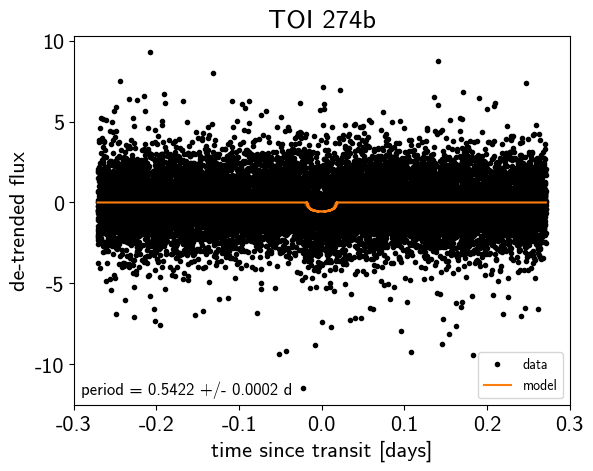

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

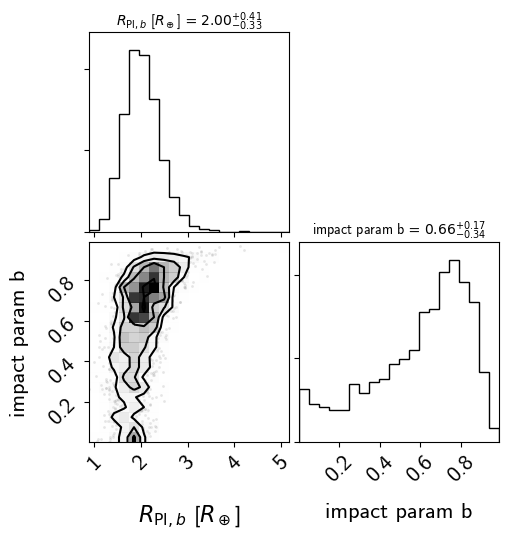

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

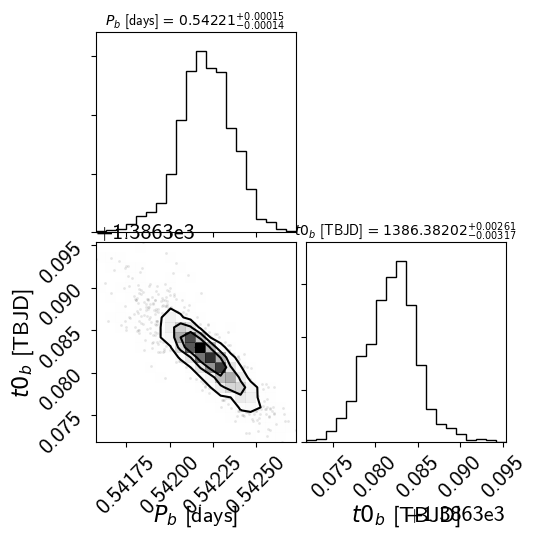

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

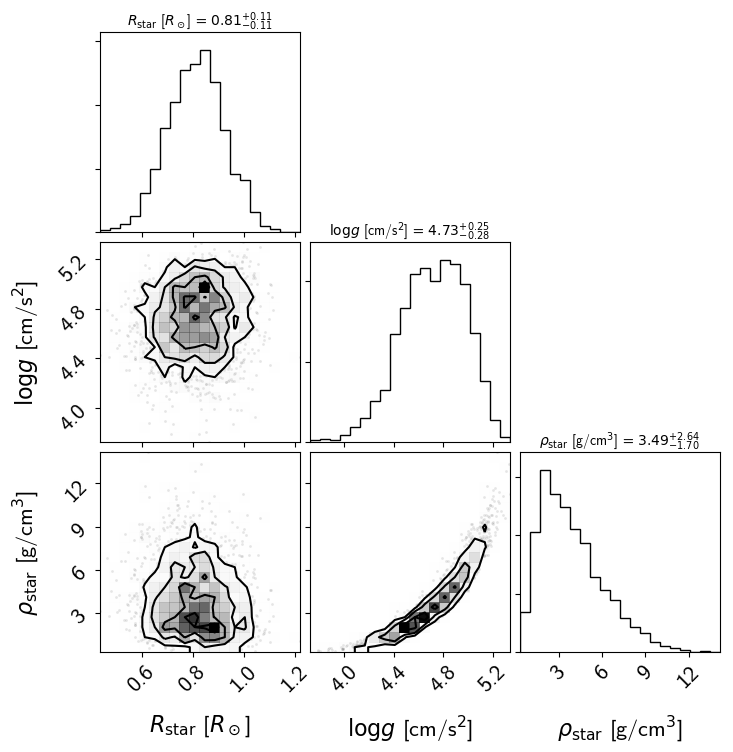

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3